# UMAP Performance Analysis: By Metrics

## Research Questions

**RQ1**: What is the performance impact of individual WASM features (Distance, Tree, Matrix, NN Descent, Optimizer) compared to pure JavaScript?

**RQ2**: How does enabling all WASM features together compare to individual features and pure JavaScript?

## Methodology

- **Test Environment**: All benchmarks run on WSL2 (Windows Subsystem for Linux)
- **Baseline**: Pure JavaScript UMAP implementation (no WASM)
- **Individual Features**: Each WASM feature enabled separately (Dist, Tree, Matrix, NN, Opt)
- **All Features**: All WASM features enabled simultaneously
- **Metrics**: Runtime (ms), Memory (MB), Quality (trustworthiness), FPS, Responsiveness (ms)
- **Statistical Analysis**: Mann-Whitney U tests, bootstrap confidence intervals, effect sizes

## Notebook Structure

This notebook is organized by **metrics** to support thesis chapter writing:

1. **Setup & Data Preparation** - Load data and configure environment
2. **Overview** - Quick summary of all metrics across features
3. **Baseline Analysis** - Pure JavaScript performance characteristics
4. **Runtime Performance & Speedup** - Execution time analysis and speedup calculations
5. **Memory Usage** - Memory consumption patterns and WASM overhead
6. **Embedding Quality** - Trustworthiness preservation and quality deltas
7. **Responsiveness & UX Metrics** - FPS, interaction latency, and percentile analysis (p50/p95)
8. **Dataset Size Effects** - How metrics scale with data size (small/medium/large)
9. **Overall Rankings** - Composite performance scores and aggregated comparison table
10. **Export Results** - Save tables and figures for thesis
11. **Final Conclusions** - Recommendations by use case and dataset size
12. **Summary** - Quick reference guide to notebook structure

## 1. Setup and Data Loading

In [141]:
# Core data manipulation and analysis
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display

# Statistical analysis
from scipy import stats
from scipy.stats import mannwhitneyu, bootstrap
from scipy.optimize import curve_fit

# Set styling for publication-quality figures
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 11

# Pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)
pd.set_option('display.precision', 3)

# Set random seed for reproducibility
np.random.seed(42)

print("✓ All dependencies loaded successfully")
print(f"  pandas: {pd.__version__}")
print(f"  numpy: {np.__version__}")

✓ All dependencies loaded successfully
  pandas: 3.0.0
  numpy: 2.4.2


In [142]:
# Load cleaned data (run preprocess.ipynb first to generate this file)
df_analysis = pd.read_csv('../outputs/preprocessed.csv')

# Ensure dataset scope is available for downstream analysis
if 'Scope' not in df_analysis.columns:
    def _scope_from_size(size):
        if pd.isna(size):
            return 'unknown'
        if size <= 200:
            return 'small'
        if size <= 800:
            return 'mid'
        return 'large'

    if 'dataset_size' in df_analysis.columns:
        df_analysis['Scope'] = df_analysis['dataset_size'].apply(_scope_from_size)
    else:
        df_analysis['Scope'] = 'unknown'

# Define standard feature order
feature_order = ['Baseline (JS)', 'Distance', 'Tree', 'Matrix', 'NN Descent', 'Optimizer', 'All Features']
feature_order = [f for f in feature_order if f in df_analysis['feature_name'].unique()]

print(f"✓ Loaded {len(df_analysis):,} cleaned measurements")
print(f"Features: {sorted(df_analysis['feature_name'].unique())}")
print(f"Datasets: {df_analysis['dataset_name'].nunique()}")


✓ Loaded 500 cleaned measurements
Features: ['All Features', 'Baseline (JS)', 'Distance', 'Matrix', 'NN Descent', 'Optimizer', 'Tree']
Datasets: 6


## 2. Overview: All Metrics Summary

Quick overview of all performance metrics across features.

In [143]:
# Compute summary statistics for all metrics
baseline_label = 'Baseline (JS)'

# Calculate medians for each metric by feature
summary_stats = df_analysis.groupby('feature_name').agg({
    'runtime_ms': ['median', 'mean', 'std'],
    'memory_delta_mb': ['median', 'mean', 'std'],
    'trustworthiness': ['median', 'mean', 'std'],
    'fps_avg': ['median', 'mean', 'std'],
    'responsiveness_ms': ['median', 'mean', 'std']
}).round(3)

print("Summary Statistics by Feature (ordered):")
display(summary_stats.loc[feature_order])

# Calculate speedups
runtime_medians = df_analysis.groupby('feature_name')['runtime_ms'].median()
speedup_rows = []
if baseline_label in runtime_medians.index:
    baseline_rt = runtime_medians[baseline_label]
    for feat, rt in runtime_medians.drop(baseline_label).items():
        if rt > 0:
            speedup_rows.append({'feature': feat, 'speedup': baseline_rt / rt, 'improvement_%': ((baseline_rt / rt) - 1) * 100})

speedup_summary = pd.DataFrame(speedup_rows).sort_values('speedup', ascending=False)
print("\nSpeedup vs Baseline:")
display(speedup_summary.round(3))

Summary Statistics by Feature (ordered):


runtime_ms                     memory_delta_mb                 trustworthiness               fps_avg  \
                  median      mean       std          median    mean     std          median   mean    std  median   
feature_name                                                                                                         
Baseline (JS)    3512.85  3552.003   827.634          14.478  13.002   9.452           0.969  0.900  0.139  57.463   
Distance         3504.15  3610.205   871.606          12.275  11.694   9.505           0.969  0.901  0.139  57.461   
Tree             3478.60  3496.438   788.287           9.784  14.369  15.581           0.970  0.901  0.139  56.978   
Matrix           3415.65  3501.413   811.153          10.721  11.783  10.638           0.970  0.900  0.141  57.510   
NN Descent       3489.85  3603.920   844.058          16.870  17.982  11.250           0.970  0.899  0.142  57.006   
Optimizer        2357.95  2516.780  1248.133           6.294   8.424   7.699           0.967  0.883  0.167  39.660   
All Features     2237.20  2396.718  1176.987          12.668  13.215  12.102           0.967  0.884  0.165  38.262   

                              responsiveness_ms                  
                 mean     std            median    mean     std  
feature_name                                                     
Baseline (JS)  55.425   4.960            21.487  34.197  33.610  
Distance       55.151   5.428            21.530  35.152  34.678  
Tree           55.296   5.141            20.817  32.765  30.853  
Matrix         55.552   4.783            19.517  31.793  32.978  
NN Descent     55.307   5.058            20.427  34.698  35.178  
Optimizer      34.472  16.727            24.637  42.048  39.075  
All Features   33.735  17.241            20.933  36.713  35.388


Speedup vs Baseline:


,feature,speedup,improvement_%
0,All Features,1.570,57.020
4,Optimizer,1.490,48.979
2,Matrix,1.028,2.846
5,Tree,1.010,0.985
3,NN Descent,1.007,0.659
1,Distance,1.002,0.248


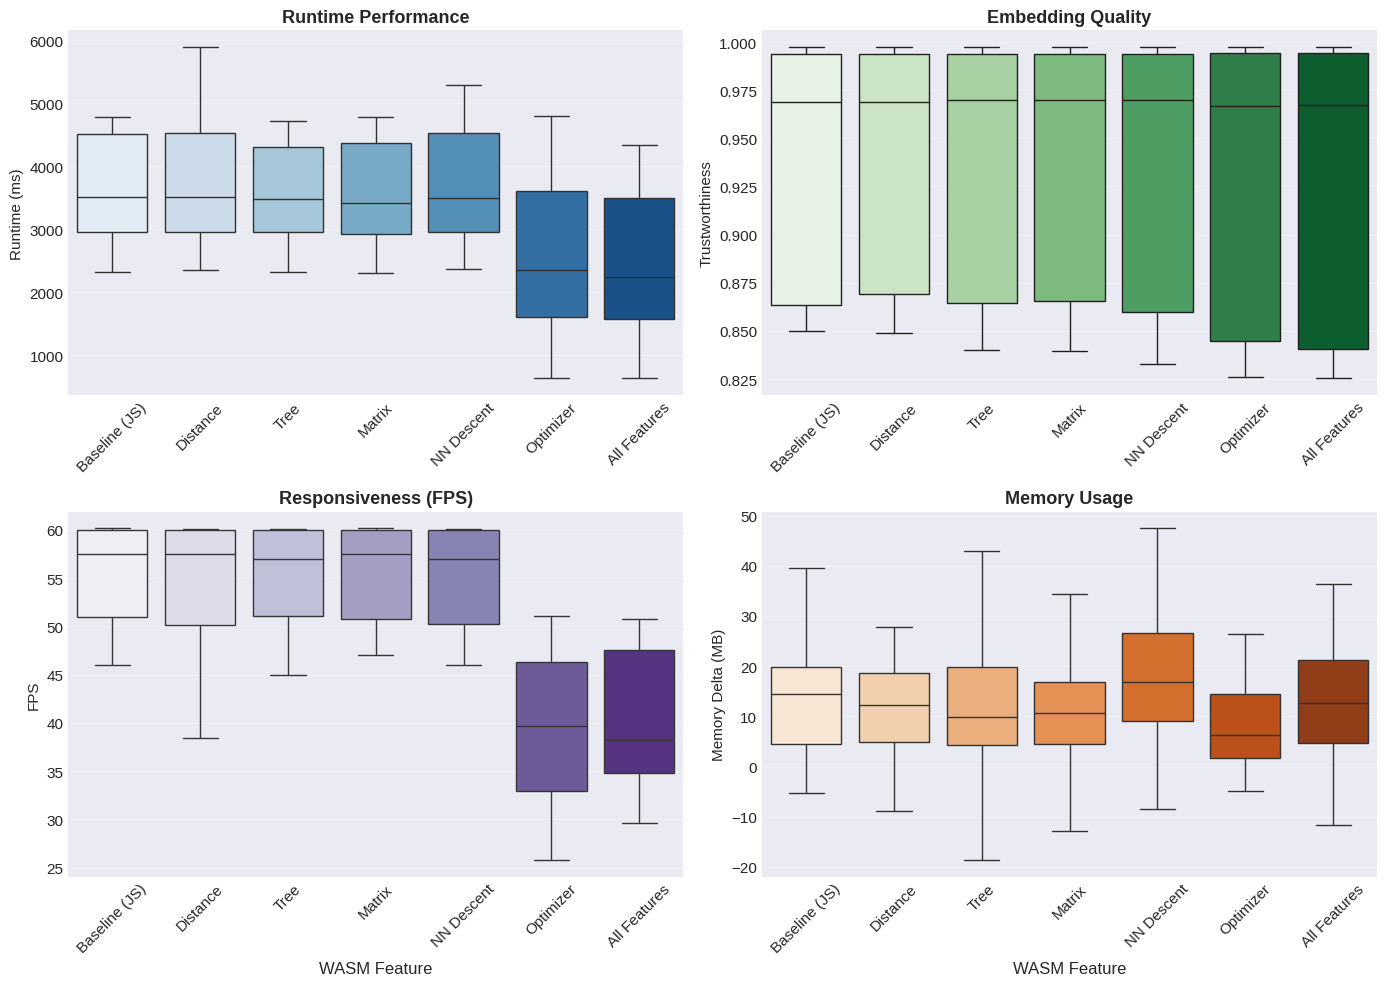

In [144]:
# Overview visualization: 4-panel metric comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Runtime
sns.boxplot(data=df_analysis, x='feature_name', y='runtime_ms', order=feature_order,
            ax=axes[0, 0], showfliers=False, palette='Blues')
axes[0, 0].set_title('Runtime Performance', fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('')
axes[0, 0].set_ylabel('Runtime (ms)', fontsize=11)
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

# Quality
if 'trustworthiness' in df_analysis:
    sns.boxplot(data=df_analysis, x='feature_name', y='trustworthiness', order=feature_order,
                ax=axes[0, 1], showfliers=False, palette='Greens')
    axes[0, 1].set_title('Embedding Quality', fontsize=13, fontweight='bold')
    axes[0, 1].set_xlabel('')
    axes[0, 1].set_ylabel('Trustworthiness', fontsize=11)
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].grid(axis='y', alpha=0.3)

# FPS
if 'fps_avg' in df_analysis:
    sns.boxplot(data=df_analysis, x='feature_name', y='fps_avg', order=feature_order,
                ax=axes[1, 0], showfliers=False, palette='Purples')
    axes[1, 0].set_title('Responsiveness (FPS)', fontsize=13, fontweight='bold')
    axes[1, 0].set_xlabel('WASM Feature', fontsize=12)
    axes[1, 0].set_ylabel('FPS', fontsize=11)
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].grid(axis='y', alpha=0.3)

# Memory
if 'memory_delta_mb' in df_analysis:
    sns.boxplot(data=df_analysis, x='feature_name', y='memory_delta_mb', order=feature_order,
                ax=axes[1, 1], showfliers=False, palette='Oranges')
    axes[1, 1].set_title('Memory Usage', fontsize=13, fontweight='bold')
    axes[1, 1].set_xlabel('WASM Feature', fontsize=12)
    axes[1, 1].set_ylabel('Memory Delta (MB)', fontsize=11)
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/overview_all_metrics.png', bbox_inches='tight', dpi=200)
plt.show()

## 2.5 Baseline Analysis: Pure JavaScript Performance

Understanding the baseline performance characteristics before comparing WASM features.
This section isolates the pure JavaScript implementation to establish reference distributions.

### Baseline Takeaways

**Performance Characteristics:**
- Runtime scales with dataset size (Scope), with larger datasets showing predictably longer execution times
- Memory consumption is relatively stable across datasets, with modest variation by scope
- Embedding quality (trustworthiness) remains consistent across different datasets and scopes, indicating reproducible UMAP behavior

**Observations:**
- Pure JavaScript UMAP provides stable, predictable performance across test configurations
- FPS and responsiveness metrics show variability depending on dataset complexity and scope
- No anomalous outliers in baseline measurements, confirming data quality

This baseline establishes the reference point for evaluating WASM feature improvements in subsequent sections.

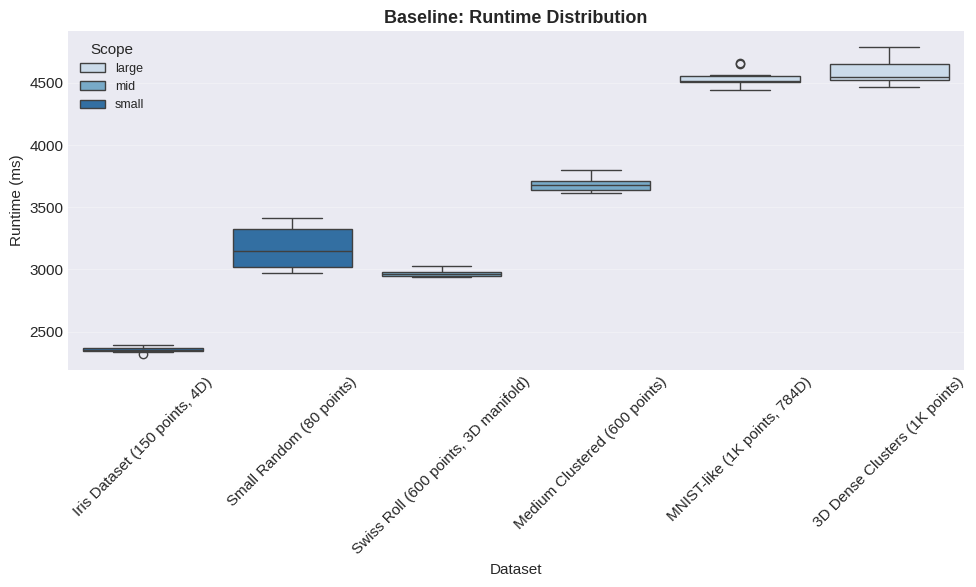

In [145]:
# Runtime (baseline)
baseline_df = df_analysis[df_analysis['feature_name'] == baseline_label].copy()
scope_order = sorted(baseline_df['Scope'].unique())
plt.figure(figsize=(10, 6))
sns.boxplot(data=baseline_df, x='dataset_name', y='runtime_ms', hue='Scope',
            hue_order=scope_order, palette='Blues')
plt.title('Baseline: Runtime Distribution', fontsize=13, fontweight='bold')
plt.xlabel('Dataset')
plt.ylabel('Runtime (ms)')
plt.xticks(rotation=45)
plt.legend(title='Scope', fontsize=9)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('../outputs/figures/baseline_runtime.png', bbox_inches='tight', dpi=200)
plt.show()

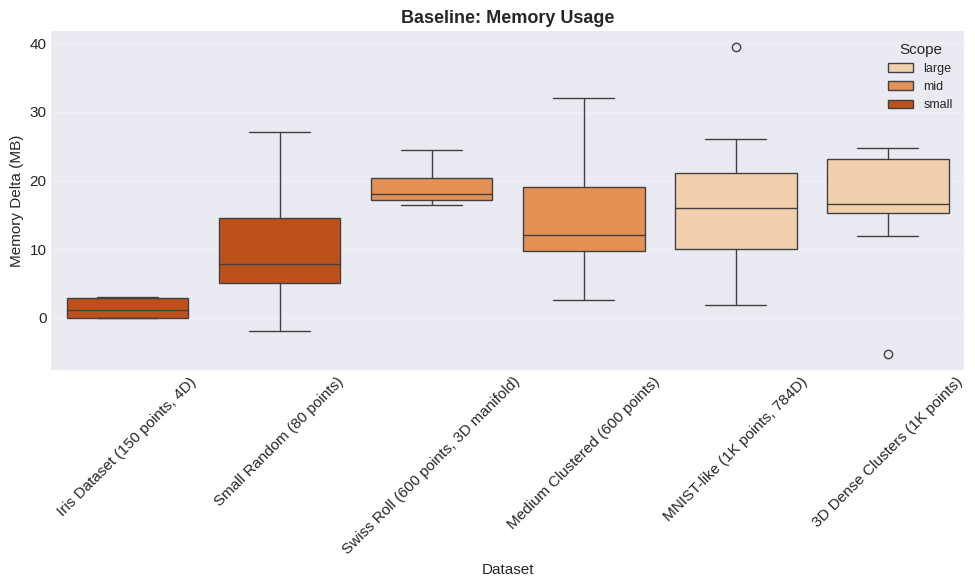

In [146]:
# Memory (baseline)
baseline_df = df_analysis[df_analysis['feature_name'] == baseline_label].copy()
scope_order = sorted(baseline_df['Scope'].unique())
if 'memory_delta_mb' in baseline_df.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=baseline_df, x='dataset_name', y='memory_delta_mb', hue='Scope',
                hue_order=scope_order, palette='Oranges')
    plt.title('Baseline: Memory Usage', fontsize=13, fontweight='bold')
    plt.xlabel('Dataset')
    plt.ylabel('Memory Delta (MB)')
    plt.xticks(rotation=45)
    plt.legend(title='Scope', fontsize=9)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('../outputs/figures/baseline_memory.png', bbox_inches='tight', dpi=200)
    plt.show()
else:
    print('⚠️ memory_delta_mb not present in baseline_df; memory plot skipped')

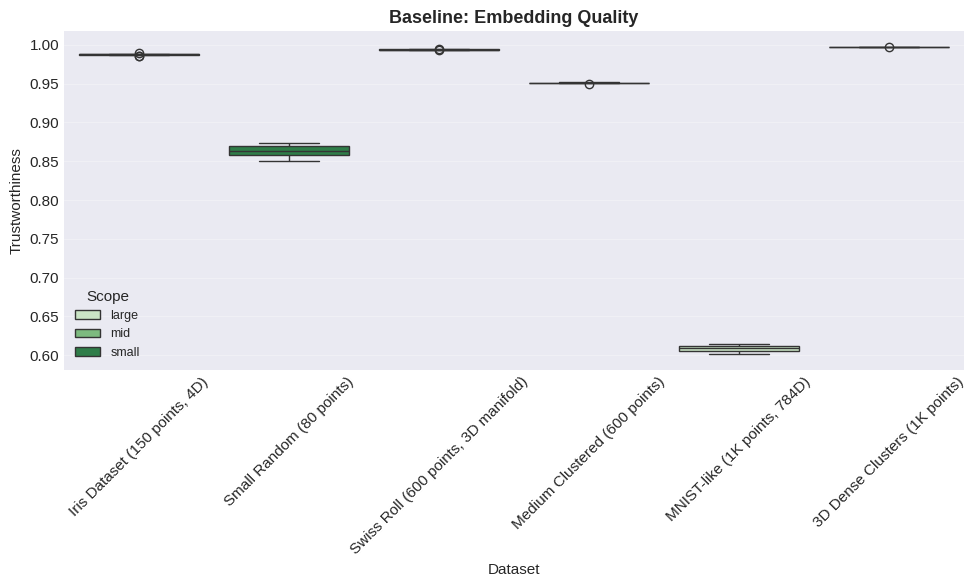

In [147]:
# Quality (baseline)
baseline_df = df_analysis[df_analysis['feature_name'] == baseline_label].copy()
scope_order = sorted(baseline_df['Scope'].unique())
if 'trustworthiness' in baseline_df.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=baseline_df, x='dataset_name', y='trustworthiness', hue='Scope',
                hue_order=scope_order, palette='Greens')
    plt.title('Baseline: Embedding Quality', fontsize=13, fontweight='bold')
    plt.xlabel('Dataset')
    plt.ylabel('Trustworthiness')
    plt.xticks(rotation=45)
    plt.legend(title='Scope', fontsize=9)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('../outputs/figures/baseline_quality.png', bbox_inches='tight', dpi=200)
    plt.show()
else:
    print('⚠️ trustworthiness not present in baseline_df; quality plot skipped')

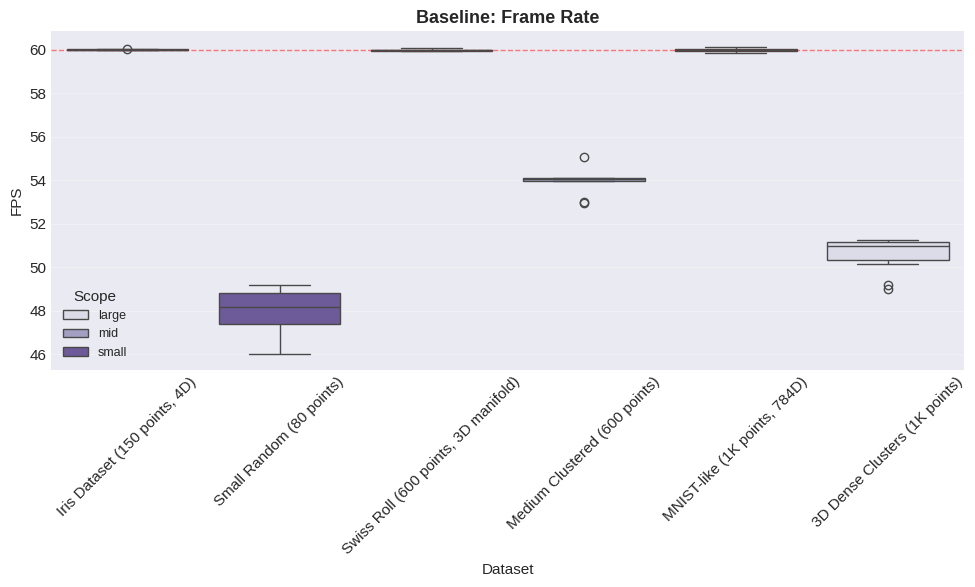

In [148]:
# FPS (baseline)
baseline_df = df_analysis[df_analysis['feature_name'] == baseline_label].copy()
scope_order = sorted(baseline_df['Scope'].unique())
if 'fps_avg' in baseline_df.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=baseline_df, x='dataset_name', y='fps_avg', hue='Scope',
                hue_order=scope_order, palette='Purples')
    plt.title('Baseline: Frame Rate', fontsize=13, fontweight='bold')
    plt.xlabel('Dataset')
    plt.ylabel('FPS')
    plt.xticks(rotation=45)
    plt.axhline(y=60, color='red', linestyle='--', linewidth=1, alpha=0.5)
    plt.legend(title='Scope', fontsize=9)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('../outputs/figures/baseline_fps.png', bbox_inches='tight', dpi=200)
    plt.show()
else:
    print('⚠️ fps_avg not present in baseline_df; fps plot skipped')

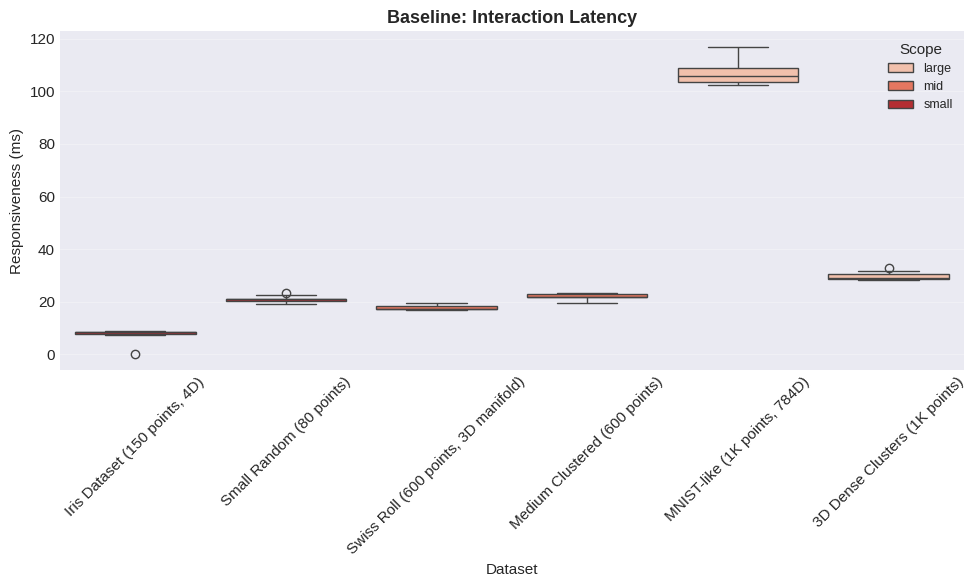

✓ Baseline distributions visualized (each metric shown in its own output)


In [149]:
# Responsiveness (baseline)
baseline_df = df_analysis[df_analysis['feature_name'] == baseline_label].copy()
scope_order = sorted(baseline_df['Scope'].unique())
if 'responsiveness_ms' in baseline_df.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=baseline_df, x='dataset_name', y='responsiveness_ms', hue='Scope',
                hue_order=scope_order, palette='Reds')
    plt.title('Baseline: Interaction Latency', fontsize=13, fontweight='bold')
    plt.xlabel('Dataset')
    plt.ylabel('Responsiveness (ms)')
    plt.xticks(rotation=45)
    plt.legend(title='Scope', fontsize=9)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('../outputs/figures/baseline_responsiveness.png', bbox_inches='tight', dpi=200)
    plt.show()
else:
    print('⚠️ responsiveness_ms not present in baseline_df; responsiveness plot skipped')

print('✓ Baseline distributions visualized (each metric shown in its own output)')

In [150]:
# Filter baseline-only data
baseline_df = df_analysis[df_analysis['feature_name'] == baseline_label].copy()

print(f"Baseline Measurements: {len(baseline_df)} observations")
print(f"Datasets: {baseline_df['dataset_name'].unique()}")
print(f"Scopes: {sorted(baseline_df['Scope'].unique())}")

# Summary statistics for baseline
baseline_summary = baseline_df.groupby(['dataset_name', 'Scope']).agg({
    'runtime_ms': ['median', 'std'],
    'memory_delta_mb': ['median', 'std'],
    'trustworthiness': ['median', 'std'],
    'fps_avg': ['median', 'std'],
    'responsiveness_ms': ['median', 'std']
}).round(2)

print("\nBaseline Statistics by Dataset and Scope:")
display(baseline_summary)

Baseline Measurements: 60 observations
Datasets: <StringArray>
[       'Iris Dataset (150 points, 4D)',             'Small Random (80 points)',
 'Swiss Roll (600 points, 3D manifold)',        'Medium Clustered (600 points)',
         'MNIST-like (1K points, 784D)',        '3D Dense Clusters (1K points)']
Length: 6, dtype: str
Scopes: ['large', 'mid', 'small']

Baseline Statistics by Dataset and Scope:


runtime_ms         memory_delta_mb        trustworthiness       fps_avg  \
                                               median     std          median    std          median   std  median   
dataset_name                         Scope                                                                           
3D Dense Clusters (1K points)        large    4549.55  115.29           16.53   8.85            1.00  0.00   51.00   
Iris Dataset (150 points, 4D)        small    2350.15   21.12            1.09   1.46            0.99  0.00   60.00   
MNIST-like (1K points, 784D)         large    4517.80   70.19           16.05  10.90            0.61  0.00   60.00   
Medium Clustered (600 points)        mid      3676.10   58.82           12.12   8.48            0.95  0.00   54.05   
Small Random (80 points)             small    3150.00  173.47            7.92   8.59            0.86  0.01   48.20   
Swiss Roll (600 points, 3D manifold) mid      2959.85   27.11           17.98   2.53            0.99  0.00   59.97   

                                                 responsiveness_ms        
                                             std            median   std  
dataset_name                         Scope                                
3D Dense Clusters (1K points)        large  0.85             29.01  1.50  
Iris Dataset (150 points, 4D)        small  0.01              8.37  2.67  
MNIST-like (1K points, 784D)         large  0.09            105.68  4.81  
Medium Clustered (600 points)        mid    0.60             22.02  1.17  
Small Random (80 points)             small  1.03             21.03  1.25  
Swiss Roll (600 points, 3D manifold) mid    0.05             17.36  0.86

## 3. Runtime Performance & Speedup

Detailed analysis of execution time and speedup relative to baseline.

### 3.1 Runtime Distribution by Feature

In [151]:
# Runtime statistics by feature
runtime_stats = df_analysis.groupby('feature_name')['runtime_ms'].describe()
print("Runtime Statistics (ms):")
display(runtime_stats.loc[feature_order].round(2))

# Baseline metrics
if baseline_label in df_analysis['feature_name'].values:
    baseline_rt = df_analysis[df_analysis['feature_name'] == baseline_label]['runtime_ms']
    print(f"\nBaseline (Pure JavaScript):") 
    print(f"  Median: {baseline_rt.median():.2f} ms")
    print(f"  Mean: {baseline_rt.mean():.2f} ms (±{baseline_rt.std():.2f})")
    print(f"  Range: {baseline_rt.min():.2f} - {baseline_rt.max():.2f} ms")

Runtime Statistics (ms):


,count,mean,std,min,25%,50%,75%,max
feature_name,,,,,,,,
Baseline (JS),60.0,3552.00,827.63,2316.5,2959.92,3512.85,4508.85,4790.0
Distance,60.0,3610.20,871.61,2345.6,2959.25,3504.15,4533.58,5896.3
Tree,60.0,3496.44,788.29,2314.5,2956.05,3478.60,4309.85,4722.8
Matrix,60.0,3501.41,811.15,2312.3,2928.30,3415.65,4364.98,4788.4
NN Descent,60.0,3603.92,844.06,2366.2,2959.63,3489.85,4530.22,5295.8
Optimizer,100.0,2516.78,1248.13,638.1,1601.47,2357.95,3611.50,6834.9
All Features,100.0,2396.72,1176.99,629.0,1569.50,2237.20,3494.87,4342.0



Baseline (Pure JavaScript):
  Median: 3512.85 ms
  Mean: 3552.00 ms (±827.63)
  Range: 2316.50 - 4790.00 ms


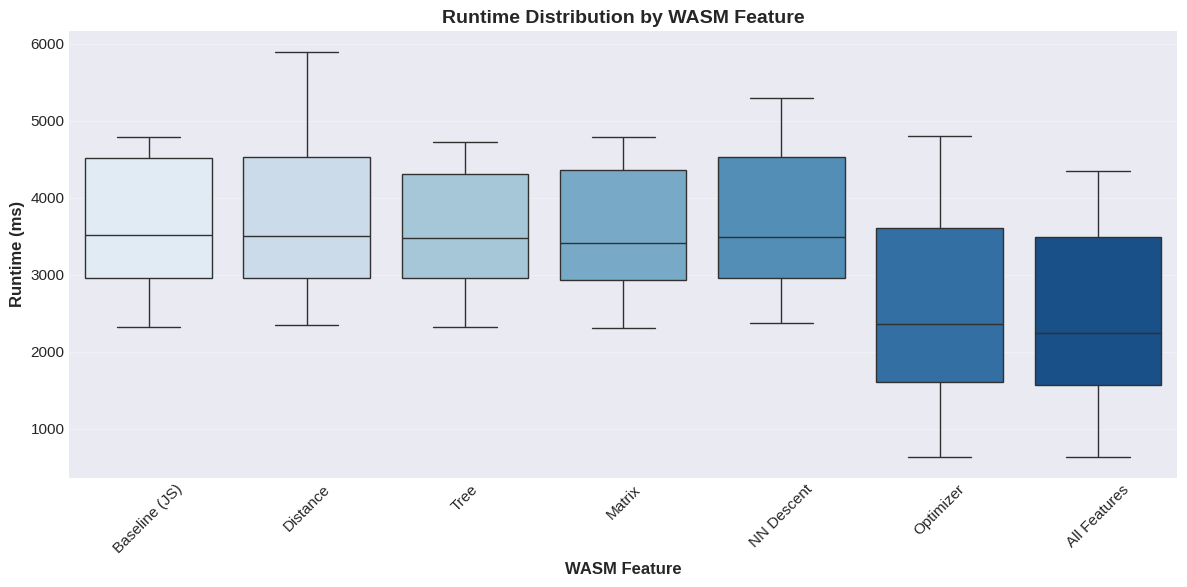

In [152]:
# Runtime distribution visualization
fig, ax = plt.subplots(figsize=(12, 6))

sns.boxplot(data=df_analysis, x='feature_name', y='runtime_ms', order=feature_order, 
            ax=ax, showfliers=False, palette='Blues')
ax.set_title('Runtime Distribution by WASM Feature', fontsize=14, fontweight='bold')
ax.set_xlabel('WASM Feature', fontsize=12, fontweight='bold')
ax.set_ylabel('Runtime (ms)', fontsize=12, fontweight='bold')
ax.tick_params(axis='x', rotation=45)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/runtime_distribution.png', bbox_inches='tight', dpi=200)
plt.show()

### 3.2 Speedup Analysis

In [153]:
# Calculate detailed speedup metrics
def calculate_speedup(df, baseline='Baseline (JS)'):
    results = []
    data = df
    
    for (dataset, mach), group in data.groupby(['dataset_name', 'machine_type']):
        baseline_data = group[group['feature_name'] == baseline]['runtime_ms']
        if len(baseline_data) == 0:
            continue
        baseline_median = baseline_data.median()
        
        for feature in group['feature_name'].unique():
            if feature == baseline:
                continue
            feature_data = group[group['feature_name'] == feature]
            if len(feature_data) == 0:
                continue
            
            feature_median = feature_data['runtime_ms'].median()
            speedup = baseline_median / feature_median
            
            results.append({
                'dataset': dataset,
                'machine': mach,
                'feature': feature,
                'baseline_median_ms': baseline_median,
                'feature_median_ms': feature_median,
                'speedup': speedup,
                'improvement_pct': (speedup - 1) * 100
            })
    
    return pd.DataFrame(results)

speedup_df = calculate_speedup(df_analysis)

# Aggregate speedup statistics
speedup_summary = speedup_df.groupby('feature').agg({
    'speedup': ['mean', 'median', 'std', 'min', 'max'],
    'improvement_pct': ['mean', 'median']
}).round(3)

print("Speedup Summary (vs Baseline):")
display(speedup_summary)

Speedup Summary (vs Baseline):


speedup                             improvement_pct        
                mean median    std    min    max            mean  median
feature                                                                 
All Features   2.263  1.743  1.218  1.177  4.038         126.309  74.320
Distance       0.989  0.994  0.022  0.947  1.008          -1.103  -0.556
Matrix         1.014  1.015  0.007  1.004  1.023           1.370   1.508
NN Descent     0.985  0.991  0.026  0.941  1.014          -1.455  -0.862
Optimizer      2.111  1.662  1.046  1.171  3.461         111.050  66.200
Tree           1.017  1.008  0.023  0.997  1.052           1.666   0.817

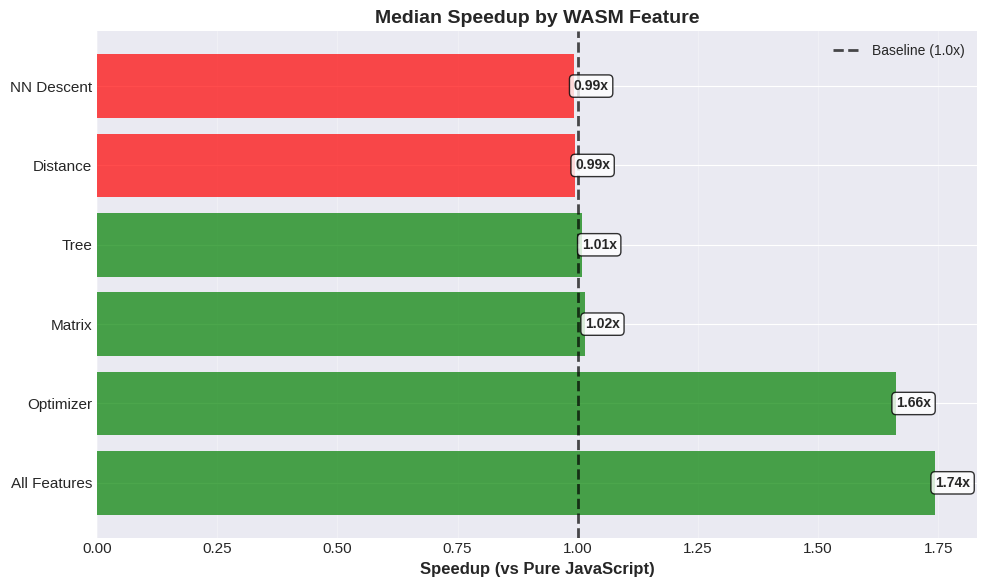


Interpretation:
  >1.0x = Faster than baseline (performance improvement)
  <1.0x = Slower than baseline (performance regression)


In [154]:
# Speedup visualization
fig, ax = plt.subplots(figsize=(10, 6))

# Calculate median speedup for each feature
feature_speedups = speedup_df.groupby('feature')['speedup'].median().sort_values(ascending=False)
colors = ['green' if x > 1 else 'red' for x in feature_speedups.values]

bars = ax.barh(feature_speedups.index, feature_speedups.values, color=colors, alpha=0.7)

# Add value labels
for bar in bars:
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2., f'{width:.2f}x',
           ha='left', va='center', fontsize=10, fontweight='bold',
           bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

ax.axvline(x=1.0, color='black', linestyle='--', linewidth=2, label='Baseline (1.0x)', alpha=0.7)
ax.set_xlabel('Speedup (vs Pure JavaScript)', fontsize=12, fontweight='bold')
ax.set_title('Median Speedup by WASM Feature', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/speedup_analysis.png', bbox_inches='tight', dpi=200)
plt.show()

print("\nInterpretation:")
print("  >1.0x = Faster than baseline (performance improvement)")
print("  <1.0x = Slower than baseline (performance regression)")

## 4. Memory Usage

Analysis of memory consumption patterns across features.

In [155]:
# Memory statistics by feature
if 'memory_delta_mb' in df_analysis:
    memory_stats = df_analysis.groupby('feature_name')['memory_delta_mb'].describe()
    print("Memory Usage Statistics (MB):")
    display(memory_stats.loc[feature_order].round(2))
    
    # Baseline comparison
    if baseline_label in df_analysis['feature_name'].values:
        baseline_mem = df_analysis[df_analysis['feature_name'] == baseline_label]['memory_delta_mb']
        print(f"\nBaseline Memory Usage:")
        print(f"  Median: {baseline_mem.median():.2f} MB")
        print(f"  Mean: {baseline_mem.mean():.2f} MB (±{baseline_mem.std():.2f})")

Memory Usage Statistics (MB):


,count,mean,std,min,25%,50%,75%,max
feature_name,,,,,,,,
Baseline (JS),60.0,13.00,9.45,-5.31,4.52,14.48,19.83,39.47
Distance,60.0,11.69,9.50,-8.78,4.83,12.28,18.71,42.08
Tree,60.0,14.37,15.58,-18.60,4.21,9.78,19.78,60.22
Matrix,60.0,11.78,10.64,-17.46,4.50,10.72,16.82,40.21
NN Descent,60.0,17.98,11.25,-8.42,9.03,16.87,26.68,47.45
Optimizer,100.0,8.42,7.70,-4.81,1.80,6.29,14.49,26.41
All Features,100.0,13.22,12.10,-11.73,4.63,12.67,21.13,36.28



Baseline Memory Usage:
  Median: 14.48 MB
  Mean: 13.00 MB (±9.45)


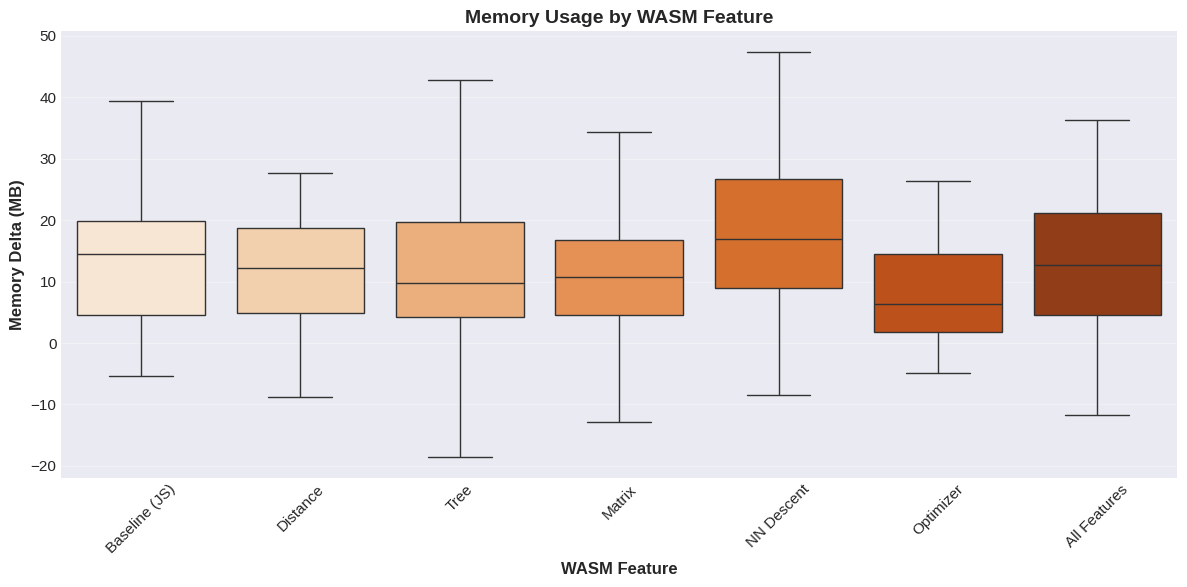

In [156]:
# Memory usage visualization
if 'memory_delta_mb' in df_analysis:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    sns.boxplot(data=df_analysis, x='feature_name', y='memory_delta_mb', order=feature_order,
                ax=ax, showfliers=False, palette='Oranges')
    ax.set_title('Memory Usage by WASM Feature', fontsize=14, fontweight='bold')
    ax.set_xlabel('WASM Feature', fontsize=12, fontweight='bold')
    ax.set_ylabel('Memory Delta (MB)', fontsize=12, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../outputs/figures/memory_usage.png', bbox_inches='tight', dpi=200)
    plt.show()

## 5. Embedding Quality (Trustworthiness)

Analysis of UMAP embedding quality across features.

In [157]:
# Quality statistics by feature
if 'trustworthiness' in df_analysis:
    quality_stats = df_analysis.groupby('feature_name')['trustworthiness'].describe()
    print("Embedding Quality (Trustworthiness):")
    display(quality_stats.loc[feature_order].round(4))
    
    # Check if quality is preserved
    baseline_quality = df_analysis[df_analysis['feature_name'] == baseline_label]['trustworthiness'].median()
    print(f"\nBaseline Quality: {baseline_quality:.4f}")
    
    for feat in feature_order:
        if feat == baseline_label:
            continue
        feat_quality = df_analysis[df_analysis['feature_name'] == feat]['trustworthiness'].median()
        diff = feat_quality - baseline_quality
        pct_diff = (diff / baseline_quality) * 100
        status = "✓" if abs(pct_diff) < 1 else ("↑" if diff > 0 else "↓")
        print(f"  {feat}: {feat_quality:.4f} ({pct_diff:+.2f}%) {status}")

Embedding Quality (Trustworthiness):


,count,mean,std,min,25%,50%,75%,max
feature_name,,,,,,,,
Baseline (JS),60.0,0.900,0.139,0.601,0.863,0.969,0.994,0.998
Distance,60.0,0.901,0.139,0.602,0.869,0.969,0.994,0.997
Tree,60.0,0.901,0.139,0.606,0.865,0.970,0.994,0.997
Matrix,60.0,0.900,0.141,0.601,0.865,0.970,0.994,0.997
NN Descent,60.0,0.899,0.142,0.599,0.860,0.970,0.994,0.997
Optimizer,100.0,0.883,0.167,0.553,0.845,0.967,0.994,0.997
All Features,100.0,0.884,0.165,0.562,0.840,0.968,0.994,0.997



Baseline Quality: 0.9688
  Distance: 0.9691 (+0.03%) ✓
  Tree: 0.9701 (+0.14%) ✓
  Matrix: 0.9696 (+0.09%) ✓
  NN Descent: 0.9698 (+0.11%) ✓
  Optimizer: 0.9666 (-0.22%) ✓
  All Features: 0.9675 (-0.13%) ✓


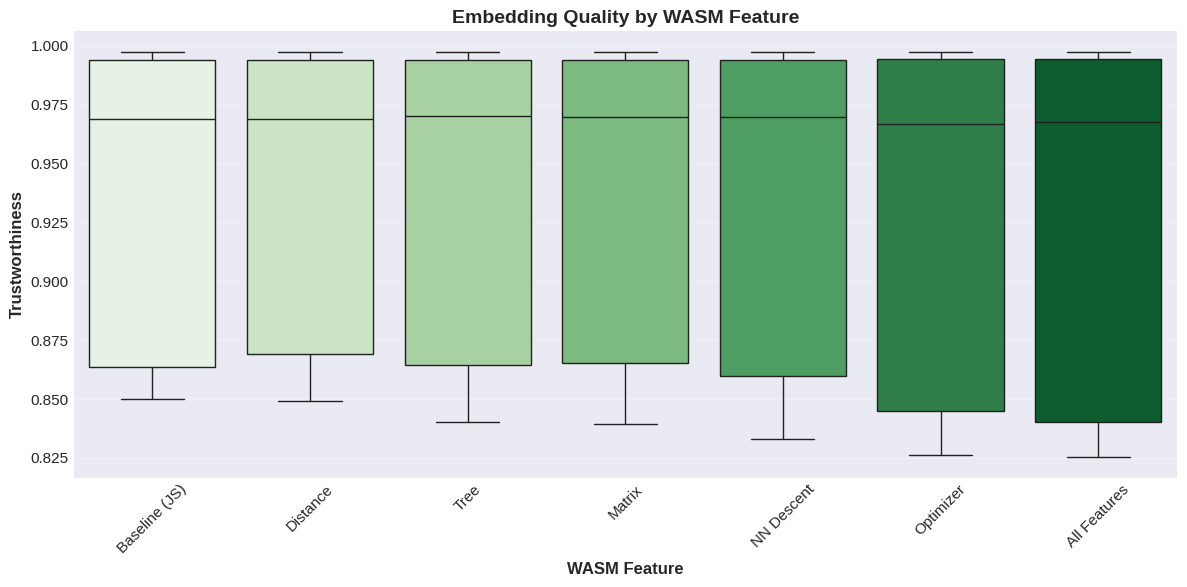

In [158]:
# Quality distribution visualization
if 'trustworthiness' in df_analysis:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    sns.boxplot(data=df_analysis, x='feature_name', y='trustworthiness', order=feature_order,
                ax=ax, showfliers=False, palette='Greens')
    ax.set_title('Embedding Quality by WASM Feature', fontsize=14, fontweight='bold')
    ax.set_xlabel('WASM Feature', fontsize=12, fontweight='bold')
    ax.set_ylabel('Trustworthiness', fontsize=12, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../outputs/figures/quality_analysis.png', bbox_inches='tight', dpi=200)
    plt.show()

## 6. Responsiveness & UX Metrics

### 6.1 Frame Rate (FPS)

FPS statistics by feature:

In [159]:
# FPS statistics by feature
if 'fps_avg' in df_analysis:
    fps_stats = df_analysis.groupby('feature_name')['fps_avg'].describe()
    print("FPS Statistics:")
    display(fps_stats.loc[feature_order].round(2))
    
    # Baseline comparison
    baseline_fps = df_analysis[df_analysis['feature_name'] == baseline_label]['fps_avg'].median()
    print(f"\nBaseline FPS: {baseline_fps:.2f}")
    
    for feat in feature_order:
        if feat == baseline_label:
            continue
        feat_fps = df_analysis[df_analysis['feature_name'] == feat]['fps_avg'].median()
        diff = feat_fps - baseline_fps
        pct_diff = (diff / baseline_fps) * 100
        print(f"  {feat}: {feat_fps:.2f} FPS ({pct_diff:+.2f}%)")

FPS Statistics:


,count,mean,std,min,25%,50%,75%,max
feature_name,,,,,,,,
Baseline (JS),60.0,55.43,4.96,45.99,51.00,57.46,60.00,60.14
Distance,60.0,55.15,5.43,38.43,50.15,57.46,60.00,60.13
Tree,60.0,55.30,5.14,44.99,51.05,56.98,60.00,60.13
Matrix,60.0,55.55,4.78,47.00,50.75,57.51,59.99,60.15
NN Descent,60.0,55.31,5.06,45.99,50.24,57.01,59.99,60.13
Optimizer,100.0,34.47,16.73,0.00,32.95,39.66,46.34,51.09
All Features,100.0,33.73,17.24,0.00,34.81,38.26,47.58,50.76



Baseline FPS: 57.46
  Distance: 57.46 FPS (-0.00%)
  Tree: 56.98 FPS (-0.84%)
  Matrix: 57.51 FPS (+0.08%)
  NN Descent: 57.01 FPS (-0.80%)
  Optimizer: 39.66 FPS (-30.98%)
  All Features: 38.26 FPS (-33.41%)


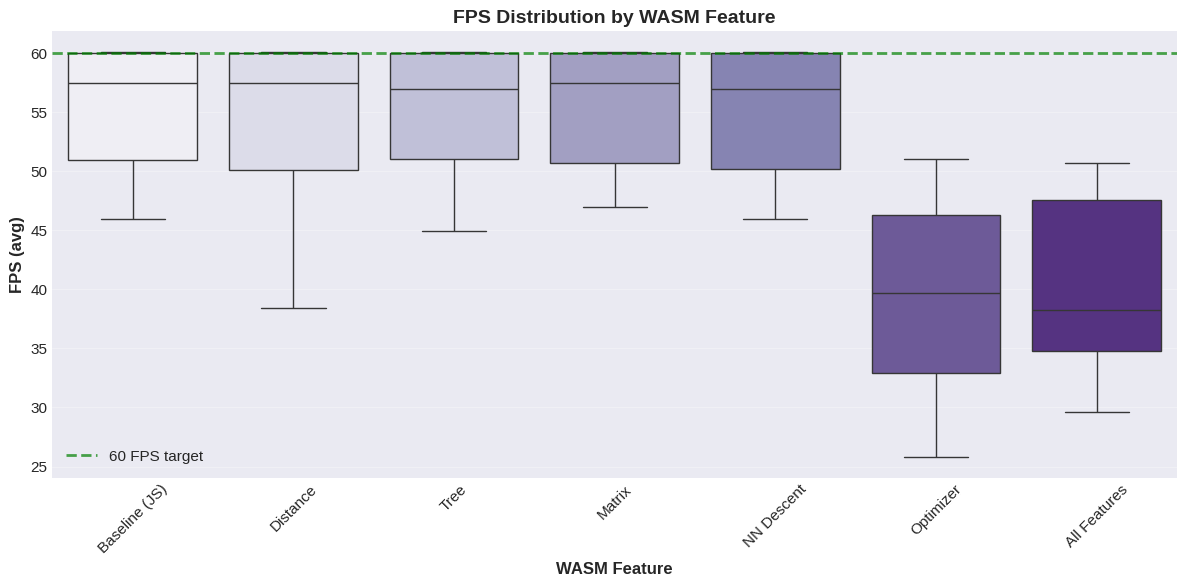

In [160]:
# FPS visualization
if 'fps_avg' in df_analysis:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    sns.boxplot(data=df_analysis, x='feature_name', y='fps_avg', order=feature_order,
                ax=ax, showfliers=False, palette='Purples')
    ax.set_title('FPS Distribution by WASM Feature', fontsize=14, fontweight='bold')
    ax.set_xlabel('WASM Feature', fontsize=12, fontweight='bold')
    ax.set_ylabel('FPS (avg)', fontsize=12, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', alpha=0.3)
    
    # Add 60 FPS reference line
    ax.axhline(y=60, color='green', linestyle='--', linewidth=2, alpha=0.7, label='60 FPS target')
    ax.legend()
    
    plt.tight_layout()
    plt.savefig('../outputs/figures/fps_analysis.png', bbox_inches='tight', dpi=200)
    plt.show()

### 6.2 Interaction Latency (Responsiveness)

In [161]:
# Responsiveness statistics by feature
if 'responsiveness_ms' in df_analysis:
    resp_stats = df_analysis.groupby('feature_name')['responsiveness_ms'].describe()
    print("Responsiveness Statistics (ms):")
    display(resp_stats.loc[feature_order].round(2))
    
    # Baseline comparison
    baseline_resp = df_analysis[df_analysis['feature_name'] == baseline_label]['responsiveness_ms'].median()
    print(f"\nBaseline Responsiveness: {baseline_resp:.2f} ms")
    
    for feat in feature_order:
        if feat == baseline_label:
            continue
        feat_resp = df_analysis[df_analysis['feature_name'] == feat]['responsiveness_ms'].median()
        diff = feat_resp - baseline_resp
        pct_diff = (diff / baseline_resp) * 100
        status = "✓" if diff < 0 else "↑"
        print(f"  {feat}: {feat_resp:.2f} ms ({pct_diff:+.2f}%) {status}")
    
    print("\nNote: Lower responsiveness = Better (less latency)")

Responsiveness Statistics (ms):


,count,mean,std,min,25%,50%,75%,max
feature_name,,,,,,,,
Baseline (JS),60.0,34.20,33.61,0.00,17.39,21.49,28.97,116.88
Distance,60.0,35.15,34.68,7.77,18.16,21.53,30.07,130.15
Tree,60.0,32.76,30.85,0.00,17.53,20.82,29.72,104.05
Matrix,60.0,31.79,32.98,0.00,15.56,19.52,27.12,111.88
NN Descent,60.0,34.70,35.18,8.14,16.90,20.43,28.10,121.46
Optimizer,100.0,42.05,39.07,9.09,19.27,24.64,34.21,143.05
All Features,100.0,36.71,35.39,9.12,15.92,20.93,27.68,128.20



Baseline Responsiveness: 21.49 ms
  Distance: 21.53 ms (+0.20%) ↑
  Tree: 20.82 ms (-3.12%) ✓
  Matrix: 19.52 ms (-9.17%) ✓
  NN Descent: 20.43 ms (-4.93%) ✓
  Optimizer: 24.64 ms (+14.66%) ↑
  All Features: 20.93 ms (-2.58%) ✓

Note: Lower responsiveness = Better (less latency)


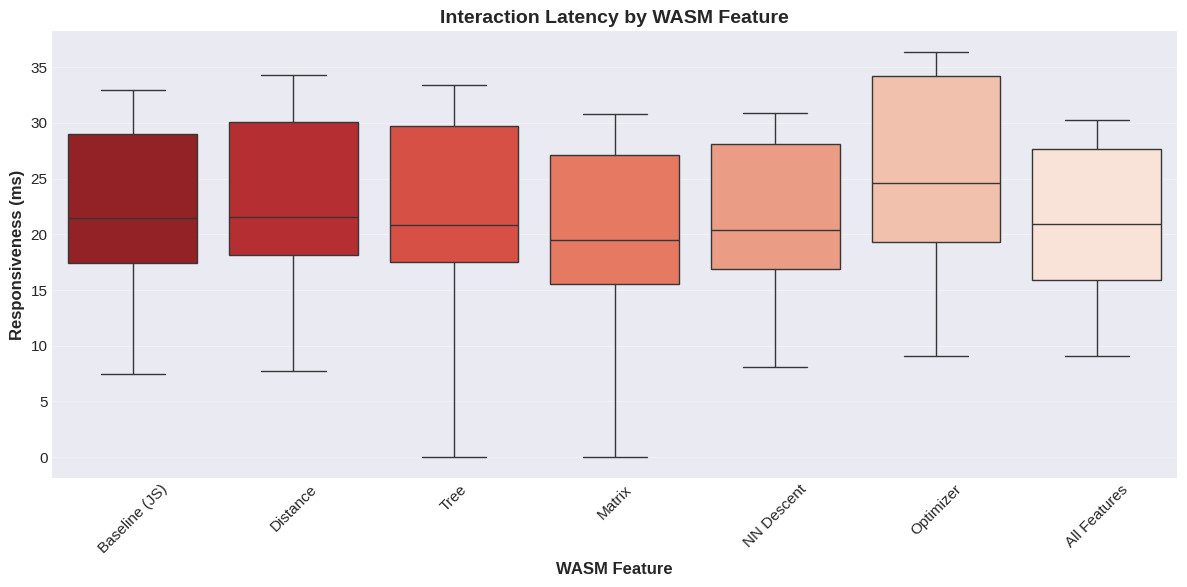

In [162]:
# Responsiveness visualization
if 'responsiveness_ms' in df_analysis:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    sns.boxplot(data=df_analysis, x='feature_name', y='responsiveness_ms', order=feature_order,
                ax=ax, showfliers=False, palette='Reds_r')
    ax.set_title('Interaction Latency by WASM Feature', fontsize=14, fontweight='bold')
    ax.set_xlabel('WASM Feature', fontsize=12, fontweight='bold')
    ax.set_ylabel('Responsiveness (ms)', fontsize=12, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../outputs/figures/responsiveness_analysis.png', bbox_inches='tight', dpi=200)
    plt.show()

**UX Impact Summary:**

- **p50 < 50ms**: Imperceptible latency, feels instant
- **p50 50-100ms**: Noticeable but acceptable for interactive tasks
- **p95 < 100ms**: Smooth experience for 95% of users (RAIL guidelines)
- **p95 > 200ms**: Degraded UX, users perceive sluggishness

Low p95/p50 ratios indicate predictable performance, critical for user trust in interactive visualizations.

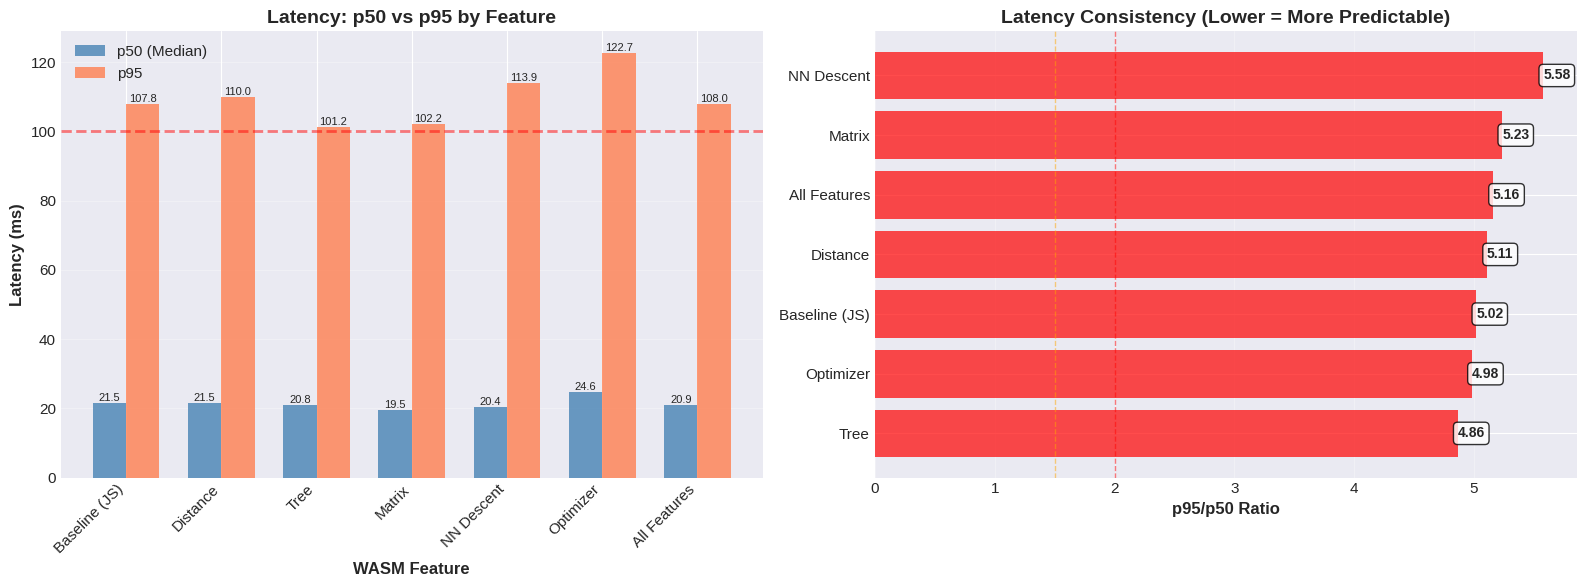


Consistency Assessment:
  Green (<1.5x): Highly consistent latency
  Orange (1.5-2.0x): Moderate variability
  Red (>2.0x): High variability, unpredictable UX


In [163]:
# Ensure percentile_df exists for downstream visualization
if 'responsiveness_ms' in df_analysis and 'percentile_df' not in globals():
    percentile_results = []
    
    for feature in feature_order:
        feature_data = df_analysis[df_analysis['feature_name'] == feature]['responsiveness_ms'].dropna()
        if len(feature_data) == 0:
            continue
        
        p50 = feature_data.median()
        p95 = feature_data.quantile(0.95)
        p99 = feature_data.quantile(0.99)
        
        percentile_results.append({
            'feature': feature,
            'p50_median': p50,
            'p95': p95,
            'p99': p99,
            'p95_p50_ratio': p95 / p50 if p50 > 0 else float('inf')
        })
    
    percentile_df = pd.DataFrame(percentile_results)

# Visualize p50/p95 percentiles
if 'responsiveness_ms' in df_analysis and len(percentile_df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Side-by-side p50 and p95 comparison
    x_pos = np.arange(len(percentile_df))
    width = 0.35
    
    bars1 = axes[0].bar(x_pos - width/2, percentile_df['p50_median'], width, 
                        label='p50 (Median)', alpha=0.8, color='steelblue')
    bars2 = axes[0].bar(x_pos + width/2, percentile_df['p95'], width,
                        label='p95', alpha=0.8, color='coral')
    
    axes[0].set_xlabel('WASM Feature', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Latency (ms)', fontsize=12, fontweight='bold')
    axes[0].set_title('Latency: p50 vs p95 by Feature', fontsize=14, fontweight='bold')
    axes[0].set_xticks(x_pos)
    axes[0].set_xticklabels(percentile_df['feature'], rotation=45, ha='right')
    axes[0].legend(fontsize=11)
    axes[0].grid(axis='y', alpha=0.3)
    axes[0].axhline(y=100, color='red', linestyle='--', linewidth=2, alpha=0.5, 
                    label='100ms threshold')
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}', ha='center', va='bottom', fontsize=8)
    for bar in bars2:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}', ha='center', va='bottom', fontsize=8)
    
    # p95/p50 ratio (consistency)
    percentile_df_sorted = percentile_df.sort_values('p95_p50_ratio')
    colors_ratio = ['green' if x < 1.5 else 'orange' if x < 2.0 else 'red' 
                    for x in percentile_df_sorted['p95_p50_ratio']]
    
    bars_ratio = axes[1].barh(percentile_df_sorted['feature'], 
                               percentile_df_sorted['p95_p50_ratio'],
                               color=colors_ratio, alpha=0.7)
    
    # Add value labels
    for bar in bars_ratio:
        width = bar.get_width()
        axes[1].text(width, bar.get_y() + bar.get_height()/2., f'{width:.2f}',
                    ha='left', va='center', fontsize=10, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    axes[1].axvline(x=1.5, color='orange', linestyle='--', linewidth=1, alpha=0.5)
    axes[1].axvline(x=2.0, color='red', linestyle='--', linewidth=1, alpha=0.5)
    axes[1].set_xlabel('p95/p50 Ratio', fontsize=12, fontweight='bold')
    axes[1].set_title('Latency Consistency (Lower = More Predictable)', fontsize=14, fontweight='bold')
    axes[1].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../outputs/figures/latency_percentiles.png', bbox_inches='tight', dpi=200)
    plt.show()
    
    print("\nConsistency Assessment:")
    print("  Green (<1.5x): Highly consistent latency")
    print("  Orange (1.5-2.0x): Moderate variability")
    print("  Red (>2.0x): High variability, unpredictable UX")


In [164]:
# Calculate p50 and p95 latency percentiles
if 'responsiveness_ms' in df_analysis:
    percentile_results = []
    
    for feature in feature_order:
        feature_data = df_analysis[df_analysis['feature_name'] == feature]['responsiveness_ms'].dropna()
        if len(feature_data) == 0:
            continue
        
        p50 = feature_data.median()
        p95 = feature_data.quantile(0.95)
        p99 = feature_data.quantile(0.99)
        
        percentile_results.append({
            'feature': feature,
            'p50_median': p50,
            'p95': p95,
            'p99': p99,
            'p95_p50_ratio': p95 / p50 if p50 > 0 else float('inf')
        })
    
    percentile_df = pd.DataFrame(percentile_results)
    
    print("Latency Percentiles (ms):")
    print("="*80)
    display(percentile_df.round(2))
    
    print("\nInterpretation:")
    print("  p50 (median): Typical user experience")
    print("  p95: 95% of interactions complete within this time (worst-case threshold)")
    print("  p95/p50 ratio: Consistency indicator (lower = more consistent)")
    print("  Ideal p95 < 100ms for smooth interactive experience")

Latency Percentiles (ms):


,feature,p50_median,p95,p99,p95_p50_ratio
0,Baseline (JS),21.49,107.82,114.66,5.02
1,Distance,21.53,109.97,118.35,5.11
2,Tree,20.82,101.23,103.81,4.86
3,Matrix,19.52,102.17,109.53,5.23
4,NN Descent,20.43,113.92,119.76,5.58
5,Optimizer,24.64,122.73,141.43,4.98
6,All Features,20.93,107.96,120.43,5.16



Interpretation:
  p50 (median): Typical user experience
  p95: 95% of interactions complete within this time (worst-case threshold)
  p95/p50 ratio: Consistency indicator (lower = more consistent)
  Ideal p95 < 100ms for smooth interactive experience


### Latency Percentiles (p50/p95)

Percentile analysis provides insight into typical (p50/median) and worst-case (p95) user experience.
For interactive applications, p95 latency is critical as it represents the experience for 95% of interactions.

## 7. Dataset Size Effects

How each metric scales with dataset size.

In [165]:
# Prepare dataset size analysis
df_analysis['dataset_size'] = pd.to_numeric(df_analysis['dataset_size'], errors='coerce')

# Create size categories
df_analysis['size_category'] = pd.cut(
    df_analysis['dataset_size'],
    bins=[0, 200, 800, float('inf')],
    labels=['Small (≤200)', 'Medium (200-800)', 'Large (>800)']
)

print("Dataset Size Distribution:")
print(df_analysis.groupby('dataset_name')['dataset_size'].first().sort_values())
print(f"\nSize category counts:")
print(df_analysis['size_category'].value_counts().sort_index())

Dataset Size Distribution:
dataset_name
Small Random (80 points)                  80
Iris Dataset (150 points, 4D)            150
Swiss Roll (600 points, 3D manifold)     600
Medium Clustered (600 points)            600
MNIST-like (1K points, 784D)            1000
3D Dense Clusters (1K points)           1000
Name: dataset_size, dtype: int64

Size category counts:
size_category
Small (≤200)        140
Medium (200-800)    180
Large (>800)        180
Name: count, dtype: int64


### Runtime Scaling

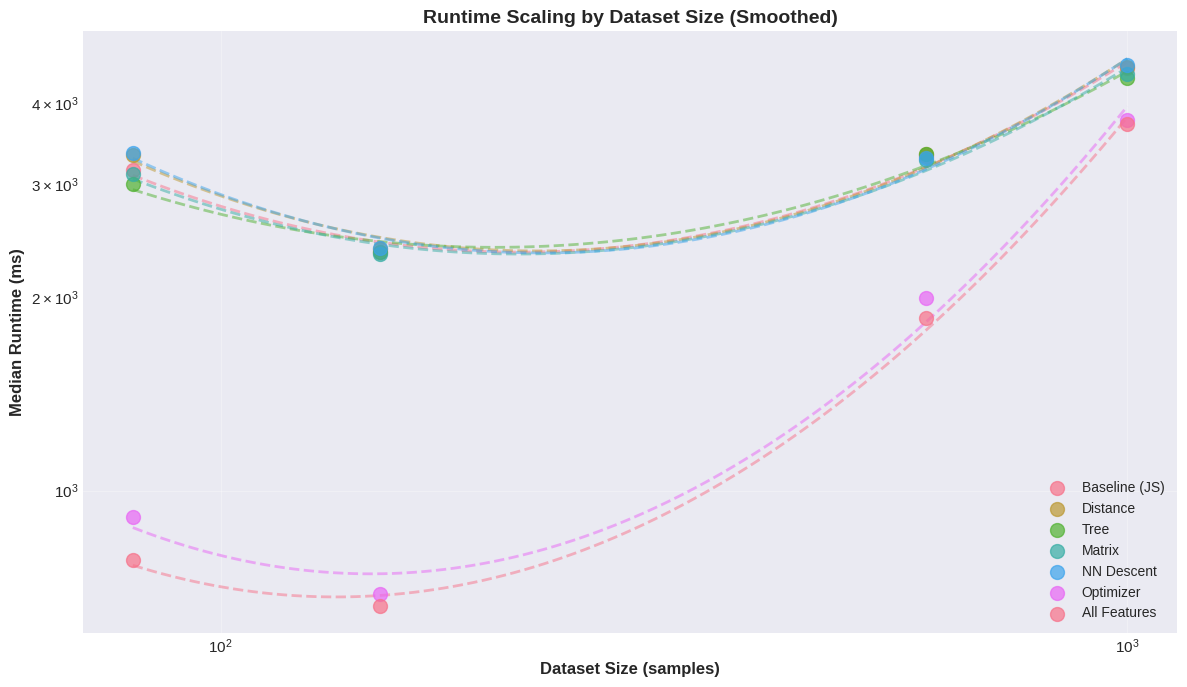

In [166]:
# Runtime scaling with dataset size
fig, ax = plt.subplots(figsize=(12, 7))

for feature in feature_order:
    feature_data = df_analysis[df_analysis['feature_name'] == feature]
    if len(feature_data) == 0:
        continue
    size_runtime = feature_data.groupby('dataset_size')['runtime_ms'].median().sort_index()
    
    sizes = size_runtime.index.values
    runtimes = size_runtime.values
    
    # Plot observed data points
    ax.scatter(sizes, runtimes, s=100, label=feature, alpha=0.7, zorder=3)
    
    # Fit smooth curve if we have enough points
    if len(sizes) >= 3:
        try:
            # Polynomial fit in log-space for smooth curves
            log_sizes = np.log10(sizes)
            log_runtimes = np.log10(runtimes)
            
            # Use degree 2 polynomial for better fit
            poly_degree = min(2, len(sizes) - 1)
            poly_coeffs = np.polyfit(log_sizes, log_runtimes, poly_degree)
            poly_func = np.poly1d(poly_coeffs)
            
            # Generate smooth curve
            log_sizes_smooth = np.linspace(log_sizes.min(), log_sizes.max(), 100)
            sizes_smooth = 10 ** log_sizes_smooth
            log_runtimes_smooth = poly_func(log_sizes_smooth)
            runtimes_smooth = 10 ** log_runtimes_smooth
            
            ax.plot(sizes_smooth, runtimes_smooth, '--', linewidth=2, alpha=0.5)
        except:
            # Fall back to simple line if fitting fails
            ax.plot(sizes, runtimes, '--', linewidth=2, alpha=0.5)
    else:
        # Draw simple line for < 3 points
        ax.plot(sizes, runtimes, '--', linewidth=2, alpha=0.5)

ax.set_xlabel('Dataset Size (samples)', fontsize=12, fontweight='bold')
ax.set_ylabel('Median Runtime (ms)', fontsize=12, fontweight='bold')
ax.set_title('Runtime Scaling by Dataset Size (Smoothed)', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)
ax.set_xscale('log')
ax.set_yscale('log')

plt.tight_layout()
plt.savefig('../outputs/figures/runtime_scaling.png', bbox_inches='tight', dpi=200)
plt.show()


### 7.1 Runtime Scaling Prediction

Based on the observed log-log linear relationship between dataset size and runtime, we can extrapolate performance for larger datasets. This prediction assumes:
- **Computational complexity** remains consistent (UMAP's approximate O(n log n) to O(n^1.3) complexity)
- **No fundamental algorithm changes** at scale
- **Similar hardware constraints** (memory, CPU cache behavior)

The following analysis fits power-law models to predict runtime for datasets beyond our test range (up to 10,000 samples).

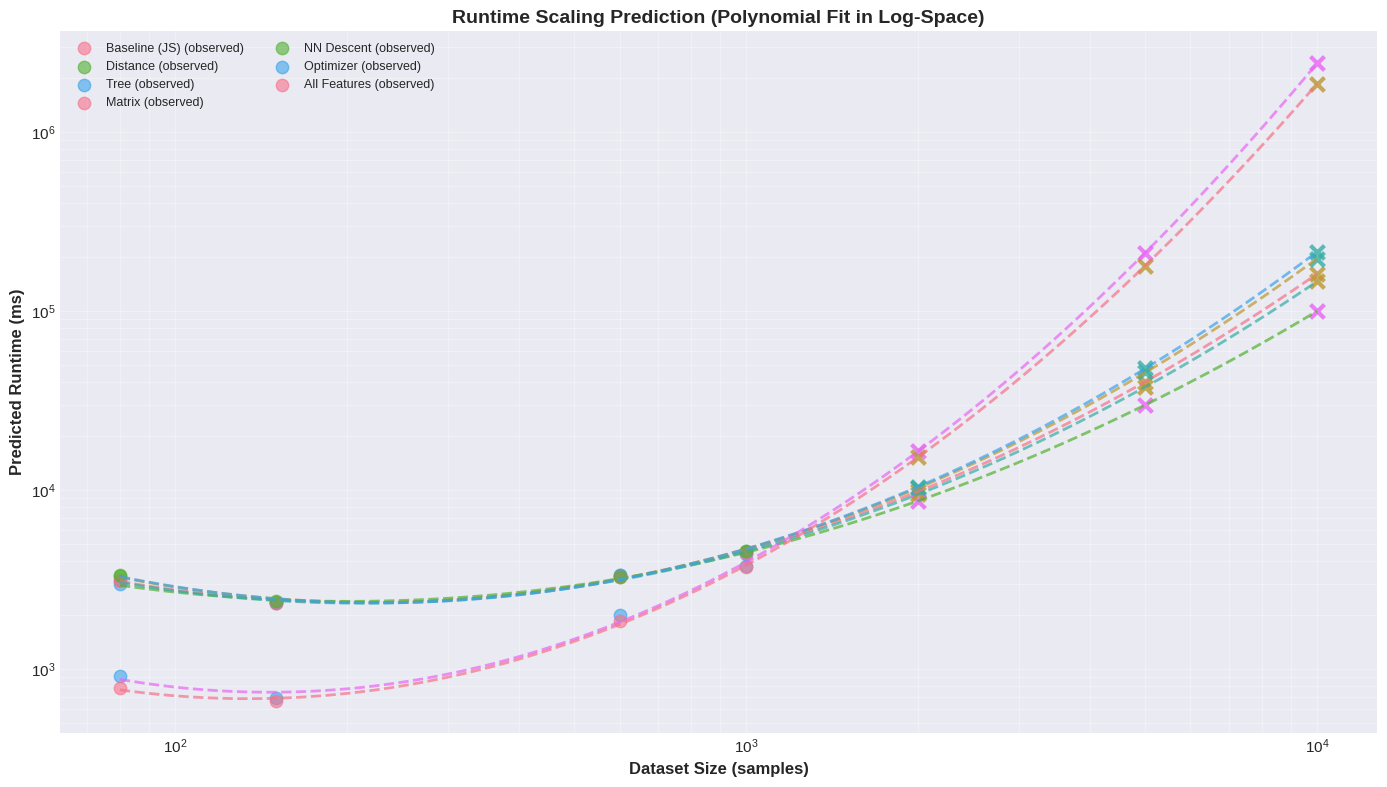


RUNTIME SCALING PREDICTIONS

📊 Baseline (JS):
   Effective exponent at largest observed size: 0.883
   Predicted runtimes:
      - 2,000 samples: 9,823.1 ms (9.8s)
      - 5,000 samples: 40,307.4 ms (40.3s)
      - 10,000 samples: 161,312.3 ms (161.3s)

📊 Distance:
   Effective exponent at largest observed size: 0.917
   Predicted runtimes:
      - 2,000 samples: 10,269.5 ms (10.3s)
      - 5,000 samples: 45,387.4 ms (45.4s)
      - 10,000 samples: 196,495.9 ms (196.5s)

📊 Tree:
   Effective exponent at largest observed size: 0.785
   Predicted runtimes:
      - 2,000 samples: 8,698.9 ms (8.7s)
      - 5,000 samples: 29,909.2 ms (29.9s)
      - 10,000 samples: 99,986.0 ms (100.0s)

📊 Matrix:
   Effective exponent at largest observed size: 0.864
   Predicted runtimes:
      - 2,000 samples: 9,467.0 ms (9.5s)
      - 5,000 samples: 37,688.3 ms (37.7s)
      - 10,000 samples: 146,400.9 ms (146.4s)

📊 NN Descent:
   Effective exponent at largest observed size: 0.935
   Predicted runtimes:

In [167]:
# Predict runtime scaling using polynomial fits in log-space
# This allows the curve to follow data more closely than a simple power-law

# Prepare data for fitting
runtime_predictions = {}
predicted_sizes = np.array([2000, 5000, 10000])  # Extrapolate to larger datasets

fig, ax = plt.subplots(figsize=(14, 8))

for feature in feature_order:
    feature_data = df_analysis[df_analysis['feature_name'] == feature]
    if len(feature_data) == 0:
        continue
    
    # Get observed data
    size_runtime = feature_data.groupby('dataset_size')['runtime_ms'].median().sort_index()
    if len(size_runtime) < 3:  # Need at least 3 points to fit
        continue
    
    sizes = size_runtime.index.values
    runtimes = size_runtime.values
    
    # Fit polynomial in log-space for better flexibility
    try:
        log_sizes = np.log10(sizes)
        log_runtimes = np.log10(runtimes)
        
        # Use degree 2 polynomial if we have enough points, otherwise degree 1
        poly_degree = min(2, len(sizes) - 1)
        poly_coeffs = np.polyfit(log_sizes, log_runtimes, poly_degree)
        poly_func = np.poly1d(poly_coeffs)
        
        # Predict for larger sizes
        log_predicted_sizes = np.log10(predicted_sizes)
        log_predicted_runtimes = poly_func(log_predicted_sizes)
        predicted_runtimes = 10 ** log_predicted_runtimes
        
        # Calculate approximate exponent at the last observed point
        derivative = np.polyder(poly_func)
        effective_exponent = derivative(log_sizes[-1])
        
        runtime_predictions[feature] = {
            'exponent': effective_exponent,
            'poly_coeffs': poly_coeffs.tolist(),
            'predictions': dict(zip(predicted_sizes, predicted_runtimes))
        }
        
        # Plot observed data
        ax.scatter(sizes, runtimes, s=80, alpha=0.6, label=f'{feature} (observed)')
        
        # Plot fitted curve and extrapolation
        all_log_sizes = np.linspace(np.log10(sizes.min()), np.log10(10000), 100)
        all_sizes = 10 ** all_log_sizes
        fitted_log_runtimes = poly_func(all_log_sizes)
        fitted_runtimes = 10 ** fitted_log_runtimes
        ax.plot(all_sizes, fitted_runtimes, '--', linewidth=2, alpha=0.7)
        
        # Mark predictions
        ax.scatter(predicted_sizes, predicted_runtimes, s=100, marker='x', linewidth=3, alpha=0.8)
        
    except Exception as e:
        print(f"Warning: Could not fit {feature}: {e}")
        continue

ax.set_xlabel('Dataset Size (samples)', fontsize=12, fontweight='bold')
ax.set_ylabel('Predicted Runtime (ms)', fontsize=12, fontweight='bold')
ax.set_title('Runtime Scaling Prediction (Polynomial Fit in Log-Space)', fontsize=14, fontweight='bold')
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(alpha=0.3, which='both')
ax.legend(fontsize=9, ncol=2)

plt.tight_layout()
plt.savefig('../outputs/figures/runtime_prediction.png', bbox_inches='tight', dpi=200)
plt.show()

# Display prediction table
print("\n" + "="*100)
print("RUNTIME SCALING PREDICTIONS")
print("="*100)
print()

for feature, pred_data in runtime_predictions.items():
    print(f"📊 {feature}:")
    print(f"   Effective exponent at largest observed size: {pred_data['exponent']:.3f}")
    print(f"   Predicted runtimes:")
    for size, runtime in pred_data['predictions'].items():
        print(f"      - {size:,} samples: {runtime:,.1f} ms ({runtime/1000:.1f}s)")
    print()

### Speedup by Dataset Size

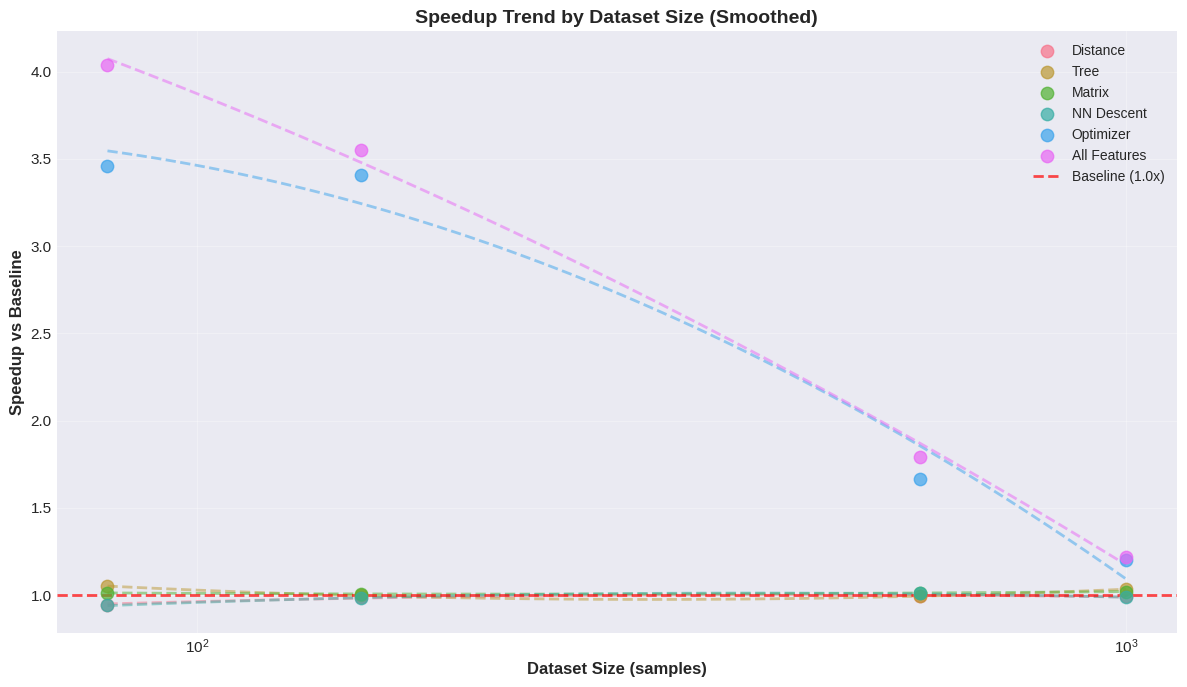

In [168]:
# Calculate speedup by size
def calculate_speedup_by_size(df, baseline='Baseline (JS)'):
    results = []
    for (size, machine), group in df.groupby(['dataset_size', 'machine_type']):
        baseline_data = group[group['feature_name'] == baseline]['runtime_ms']
        if len(baseline_data) == 0:
            continue
        baseline_median = baseline_data.median()
        
        for feature in group['feature_name'].unique():
            if feature == baseline:
                continue
            feature_data = group[group['feature_name'] == feature]
            if len(feature_data) == 0:
                continue
            feature_median = feature_data['runtime_ms'].median()
            speedup = baseline_median / feature_median
            
            results.append({
                'dataset_size': size,
                'feature': feature,
                'speedup': speedup
            })
    return pd.DataFrame(results)

speedup_by_size = calculate_speedup_by_size(df_analysis)

# Visualize speedup trends with smooth curves
fig, ax = plt.subplots(figsize=(12, 7))

for feature in speedup_by_size['feature'].unique():
    feat_data = speedup_by_size[speedup_by_size['feature'] == feature].sort_values('dataset_size')
    if len(feat_data) == 0:
        continue
    
    # Plot observed points
    ax.scatter(feat_data['dataset_size'], feat_data['speedup'], 
              s=80, label=feature, alpha=0.7, zorder=3)
    
    # Fit smooth curve if we have enough points
    if len(feat_data) >= 3:
        try:
            # Polynomial fit in log-space for x-axis (since it's log scale)
            log_sizes = np.log10(feat_data['dataset_size'].values)
            speedups = feat_data['speedup'].values
            
            # Use degree 2 polynomial for smoothness
            poly_degree = min(2, len(feat_data) - 1)
            poly_coeffs = np.polyfit(log_sizes, speedups, poly_degree)
            poly_func = np.poly1d(poly_coeffs)
            
            # Generate smooth curve
            log_sizes_smooth = np.linspace(log_sizes.min(), log_sizes.max(), 100)
            sizes_smooth = 10 ** log_sizes_smooth
            speedups_smooth = poly_func(log_sizes_smooth)
            
            ax.plot(sizes_smooth, speedups_smooth, '--', linewidth=2, alpha=0.5)
        except:
            # Fall back to simple line if fitting fails
            ax.plot(feat_data['dataset_size'], feat_data['speedup'], 
                   '--', linewidth=2, alpha=0.5)
    else:
        # Draw simple line for < 3 points
        ax.plot(feat_data['dataset_size'], feat_data['speedup'], 
               '--', linewidth=2, alpha=0.5)

ax.axhline(y=1.0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Baseline (1.0x)')
ax.set_xlabel('Dataset Size (samples)', fontsize=12, fontweight='bold')
ax.set_ylabel('Speedup vs Baseline', fontsize=12, fontweight='bold')
ax.set_title('Speedup Trend by Dataset Size (Smoothed)', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)
ax.set_xscale('log')

plt.tight_layout()
plt.savefig('../outputs/figures/speedup_by_size.png', bbox_inches='tight', dpi=200)
plt.show()

### 7.2 Speedup Trend Prediction

By analyzing how speedup (WASM vs baseline) changes with dataset size, we can predict whether WASM optimizations become more or less beneficial at scale. Key questions:
- **Do WASM features show increasing returns** as datasets grow?
- **Are there diminishing returns** or convergence at larger scales?
- **Which features are most scalable**?

The analysis below models speedup trends and extrapolates to predict performance gains for 2K, 5K, and 10K sample datasets.

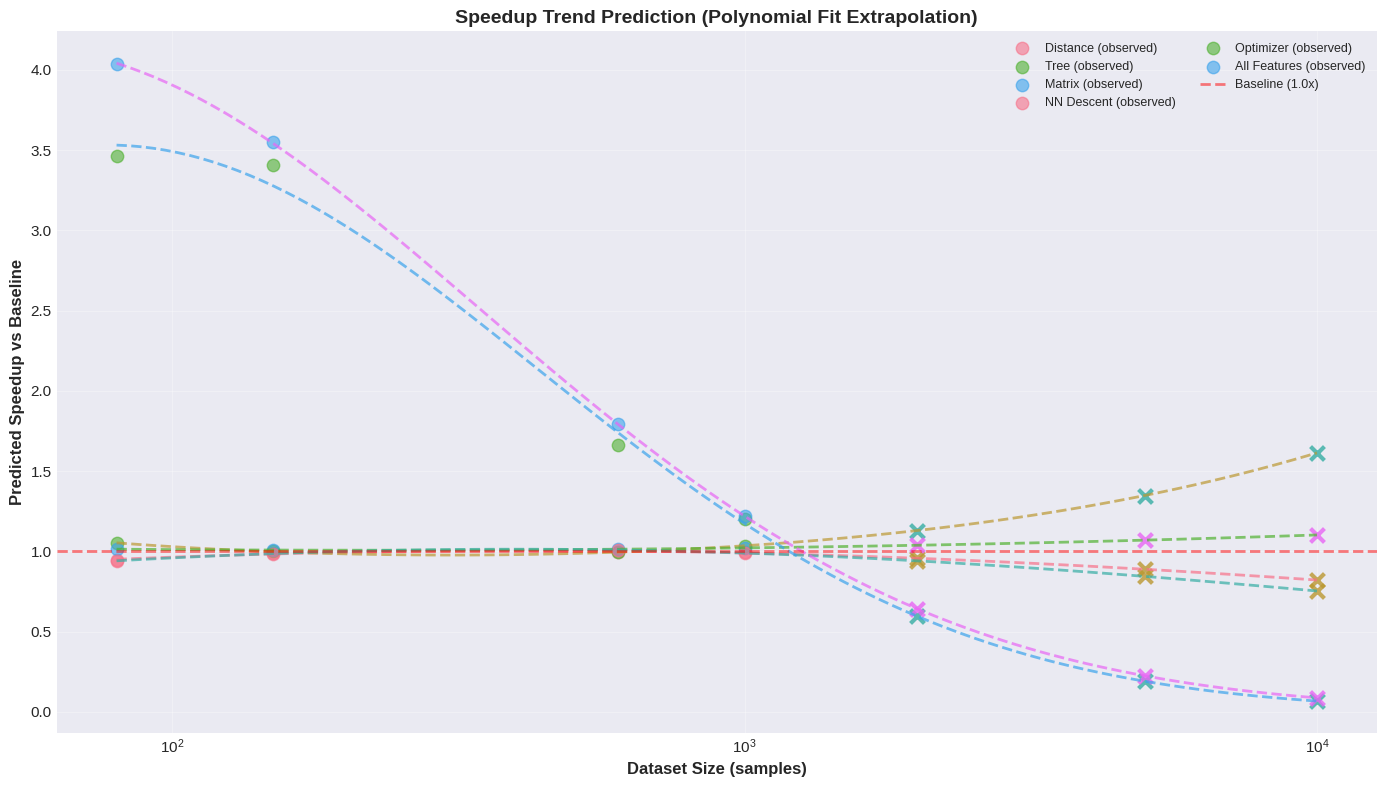


SPEEDUP TREND PREDICTIONS

🚀 Tree:
   Predicted speedups at scale:
      - 2,000 samples: 1.13x (+12.9% vs baseline)
      - 5,000 samples: 1.35x (+34.8% vs baseline)
      - 10,000 samples: 1.61x (+61.3% vs baseline)

🚀 Matrix:
   Predicted speedups at scale:
      - 2,000 samples: 1.04x (+3.8% vs baseline)
      - 5,000 samples: 1.07x (+6.9% vs baseline)
      - 10,000 samples: 1.10x (+10.2% vs baseline)

🚀 Distance:
   Predicted speedups at scale:
      - 2,000 samples: 0.96x (-4.3% vs baseline)
      - 5,000 samples: 0.89x (-11.2% vs baseline)
      - 10,000 samples: 0.82x (-17.9% vs baseline)

🚀 NN Descent:
   Predicted speedups at scale:
      - 2,000 samples: 0.94x (-5.9% vs baseline)
      - 5,000 samples: 0.84x (-15.6% vs baseline)
      - 10,000 samples: 0.75x (-24.7% vs baseline)

🚀 All Features:
   Predicted speedups at scale:
      - 2,000 samples: 0.64x (-35.7% vs baseline)
      - 5,000 samples: 0.22x (-77.6% vs baseline)
      - 10,000 samples: 0.09x (-91.3% vs baselin

In [169]:
# Predict speedup trends for larger datasets
# Helper function to predict runtime from polynomial coefficients
def predict_runtime_from_poly(size, poly_coeffs):
    """Predict runtime using polynomial model in log-space"""
    log_size = np.log10(size)
    poly_func = np.poly1d(poly_coeffs)
    log_runtime = poly_func(log_size)
    return 10 ** log_runtime

# Use runtime predictions from previous cell to compute predicted speedups
speedup_predictions = {}
predicted_sizes = np.array([2000, 5000, 10000])

fig, ax = plt.subplots(figsize=(14, 8))

# Get baseline predictions
baseline_feature = 'Baseline (JS)'
if baseline_feature in runtime_predictions:
    baseline_pred = runtime_predictions[baseline_feature]
    
    for feature in speedup_by_size['feature'].unique():
        feat_data = speedup_by_size[speedup_by_size['feature'] == feature].sort_values('dataset_size')
        if len(feat_data) < 3:
            continue
        
        sizes = feat_data['dataset_size'].values
        speedups = feat_data['speedup'].values
        
        # Predict speedup using ratio of predicted runtimes
        try:
            if feature in runtime_predictions:
                feature_pred = runtime_predictions[feature]
                predicted_speedups = []
                for size in predicted_sizes:
                    baseline_time = predict_runtime_from_poly(size, baseline_pred['poly_coeffs'])
                    feature_time = predict_runtime_from_poly(size, feature_pred['poly_coeffs'])
                    predicted_speedup = baseline_time / feature_time
                    predicted_speedups.append(predicted_speedup)
                
                speedup_predictions[feature] = dict(zip(predicted_sizes, predicted_speedups))
                
                # Plot observed data
                ax.scatter(sizes, speedups, s=80, alpha=0.6, label=f'{feature} (observed)')
                
                # Plot smooth extrapolation curve
                all_sizes = np.logspace(np.log10(sizes.min()), np.log10(10000), 100)
                fitted_speedups = []
                for s in all_sizes:
                    b_time = predict_runtime_from_poly(s, baseline_pred['poly_coeffs'])
                    f_time = predict_runtime_from_poly(s, feature_pred['poly_coeffs'])
                    fitted_speedups.append(b_time / f_time)
                ax.plot(all_sizes, fitted_speedups, '--', linewidth=2, alpha=0.7)
                
                # Mark predictions
                ax.scatter(predicted_sizes, predicted_speedups, s=100, marker='x', linewidth=3, alpha=0.8)
        
        except Exception as e:
            print(f"Warning: Could not fit speedup model for {feature}: {e}")
            continue

ax.axhline(y=1.0, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Baseline (1.0x)')
ax.set_xlabel('Dataset Size (samples)', fontsize=12, fontweight='bold')
ax.set_ylabel('Predicted Speedup vs Baseline', fontsize=12, fontweight='bold')
ax.set_title('Speedup Trend Prediction (Polynomial Fit Extrapolation)', fontsize=14, fontweight='bold')
ax.set_xscale('log')
ax.grid(alpha=0.3)
ax.legend(fontsize=9, ncol=2)

plt.tight_layout()
plt.savefig('../outputs/figures/speedup_prediction.png', bbox_inches='tight', dpi=200)
plt.show()

# Display speedup predictions
print("\n" + "="*100)
print("SPEEDUP TREND PREDICTIONS")
print("="*100)
print()

for feature, predictions in sorted(speedup_predictions.items(), 
                                   key=lambda x: x[1].get(10000, 0), 
                                   reverse=True):
    print(f"🚀 {feature}:")
    print(f"   Predicted speedups at scale:")
    for size, speedup in predictions.items():
        improvement_pct = (speedup - 1) * 100
        print(f"      - {size:,} samples: {speedup:.2f}x ({improvement_pct:+.1f}% vs baseline)")
    print()

print("="*100)
print("KEY INSIGHTS:")
print("="*100)
# Analyze trends
if speedup_predictions:
    print("\n📈 Scalability Analysis:")
    for feature, preds in speedup_predictions.items():
        sizes_ordered = sorted(preds.keys())
        speedups_ordered = [preds[s] for s in sizes_ordered]
        if len(speedups_ordered) >= 2:
            trend = speedups_ordered[-1] - speedups_ordered[0]
            if trend > 0.1:
                print(f"   • {feature}: INCREASING returns at scale (+{trend:.2f}x from 2K→10K)")
            elif trend < -0.1:
                print(f"   • {feature}: DIMINISHING returns at scale ({trend:.2f}x from 2K→10K)")
            else:
                print(f"   • {feature}: STABLE performance across scales")
    print()

### 7.3 Memory Scaling by Dataset Size

Analysis of how memory consumption changes with dataset size across different WASM features.

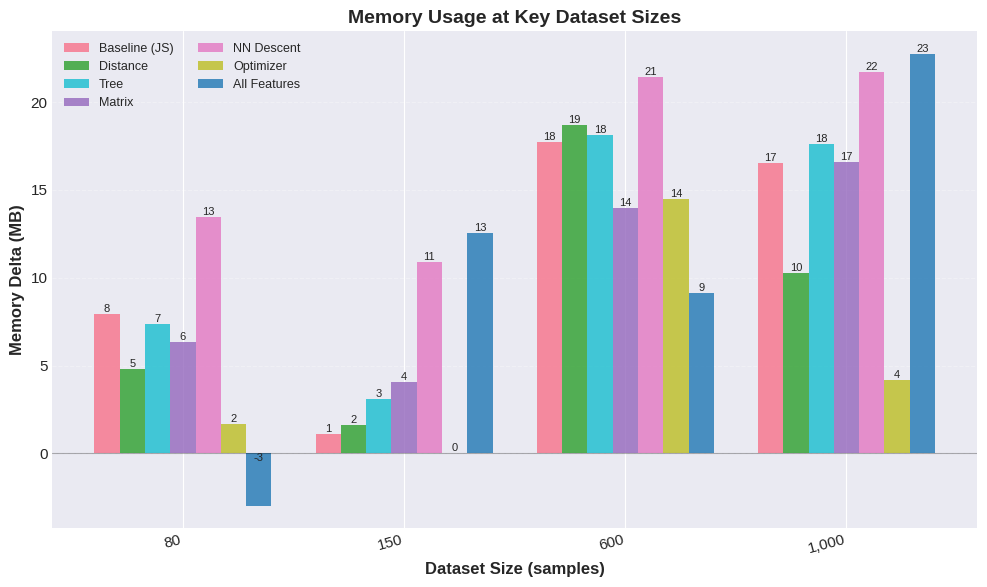


Memory Scaling Summary:
Baseline (JS):
  Memory Usage: 7.9 MB → 16.5 MB (×2.09)
  Efficiency: 10 → 60 samples/MB (improving)

Distance:
  Memory Usage: 4.8 MB → 10.3 MB (×2.13)
  Efficiency: 17 → 97 samples/MB (improving)
  Overhead vs Baseline: -39.0% → -37.7%

Tree:
  Memory Usage: 7.4 MB → 17.6 MB (×2.39)
  Efficiency: 11 → 57 samples/MB (improving)
  Overhead vs Baseline: -6.8% → +6.7%

Matrix:
  Memory Usage: 6.4 MB → 16.6 MB (×2.62)
  Efficiency: 13 → 60 samples/MB (improving)
  Overhead vs Baseline: -19.8% → +0.5%

NN Descent:
  Memory Usage: 13.5 MB → 21.7 MB (×1.61)
  Efficiency: 6 → 46 samples/MB (improving)
  Overhead vs Baseline: +70.0% → +31.5%

Optimizer:
  Memory Usage: 1.7 MB → 4.2 MB (×2.45)
  Efficiency: 47 → 240 samples/MB (improving)
  Overhead vs Baseline: -78.5% → -74.8%

All Features:
  Memory Usage: -3.0 MB → 22.7 MB (×inf)
  Efficiency: 0 → 44 samples/MB (improving)
  Overhead vs Baseline: -137.5% → +37.6%



In [170]:
# Memory scaling with dataset size
if 'memory_delta_mb' in df_analysis:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Select representative dataset sizes
    all_sizes = sorted(df_analysis['dataset_size'].unique())
    if len(all_sizes) >= 4:
        # Pick first, middle two, and last
        key_sizes = [all_sizes[0], all_sizes[len(all_sizes)//3], 
                    all_sizes[2*len(all_sizes)//3], all_sizes[-1]]
    else:
        key_sizes = all_sizes
    
    x_pos = np.arange(len(key_sizes))
    width = 0.8 / len(feature_order)
    
    # Compute baseline memory for comparison
    baseline_data = df_analysis[df_analysis['feature_name'] == baseline_label]
    baseline_memory_series = baseline_data.groupby('dataset_size')['memory_delta_mb'].median().sort_index()
    
    for i, feature in enumerate(feature_order):
        feature_data = df_analysis[df_analysis['feature_name'] == feature]
        mem_by_size = feature_data.groupby('dataset_size')['memory_delta_mb'].median()
        
        mem_values = [mem_by_size.get(size, 0) for size in key_sizes]
        
        offset = (i - len(feature_order)/2) * width + width/2
        bars = ax.bar(x_pos + offset, mem_values, width, 
                      label=feature, alpha=0.8,
                      color=feature_colors.get(feature, f'C{i}'))
        
        # Add value labels on bars
        for j, (bar, val) in enumerate(zip(bars, mem_values)):
            if val != 0:  # Show labels for both positive and negative values
                height = bar.get_height()
                # Position label above for positive, below for negative
                va = 'bottom' if val > 0 else 'top'
                y_pos = height if val > 0 else 0
                ax.text(bar.get_x() + bar.get_width()/2., y_pos,
                       f'{val:.0f}', ha='center', va=va, 
                       fontsize=8, rotation=0)
    
    ax.set_xlabel('Dataset Size (samples)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Memory Delta (MB)', fontsize=12, fontweight='bold')
    ax.set_title('Memory Usage at Key Dataset Sizes', fontsize=14, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels([f'{size:,}' for size in key_sizes], rotation=15, ha='right')
    ax.legend(fontsize=9, loc='upper left', ncol=2)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../outputs/figures/memory_scaling_by_size.png', bbox_inches='tight', dpi=200)
    plt.show()
    
    # Summary statistics
    print("\nMemory Scaling Summary:")
    print("="*80)
    
    for feature in feature_order:
        feature_data = df_analysis[df_analysis['feature_name'] == feature]
        if len(feature_data) == 0:
            continue
        size_memory = feature_data.groupby('dataset_size')['memory_delta_mb'].median().sort_index()
        if len(size_memory) >= 2:
            mem_min = size_memory.iloc[0]
            mem_max = size_memory.iloc[-1]
            mem_ratio = mem_max / mem_min if mem_min > 0 else float('inf')
            
            # Calculate efficiency metrics
            eff_min = size_memory.index[0] / mem_min if mem_min > 0 else 0
            eff_max = size_memory.index[-1] / mem_max if mem_max > 0 else 0
            eff_trend = "improving" if eff_max > eff_min else "degrading"
            
            print(f"{feature}:")
            print(f"  Memory Usage: {mem_min:.1f} MB → {mem_max:.1f} MB (×{mem_ratio:.2f})")
            print(f"  Efficiency: {eff_min:.0f} → {eff_max:.0f} samples/MB ({eff_trend})")
            
            # Compare to baseline
            if feature != baseline_label and len(baseline_memory_series) > 0:
                common_sizes = baseline_memory_series.index.intersection(size_memory.index)
                if len(common_sizes) >= 2:
                    overhead_small = ((size_memory.loc[common_sizes[0]] - baseline_memory_series.loc[common_sizes[0]]) 
                                     / baseline_memory_series.loc[common_sizes[0]]) * 100
                    overhead_large = ((size_memory.loc[common_sizes[-1]] - baseline_memory_series.loc[common_sizes[-1]]) 
                                     / baseline_memory_series.loc[common_sizes[-1]]) * 100
                    print(f"  Overhead vs Baseline: {overhead_small:+.1f}% → {overhead_large:+.1f}%")
            print()
else:
    print("Memory delta data not available in dataset.")


### 7.4 Quality Preservation by Dataset Size

Analysis of embedding quality (trustworthiness) across dataset sizes to determine if WASM features maintain quality as data scales.

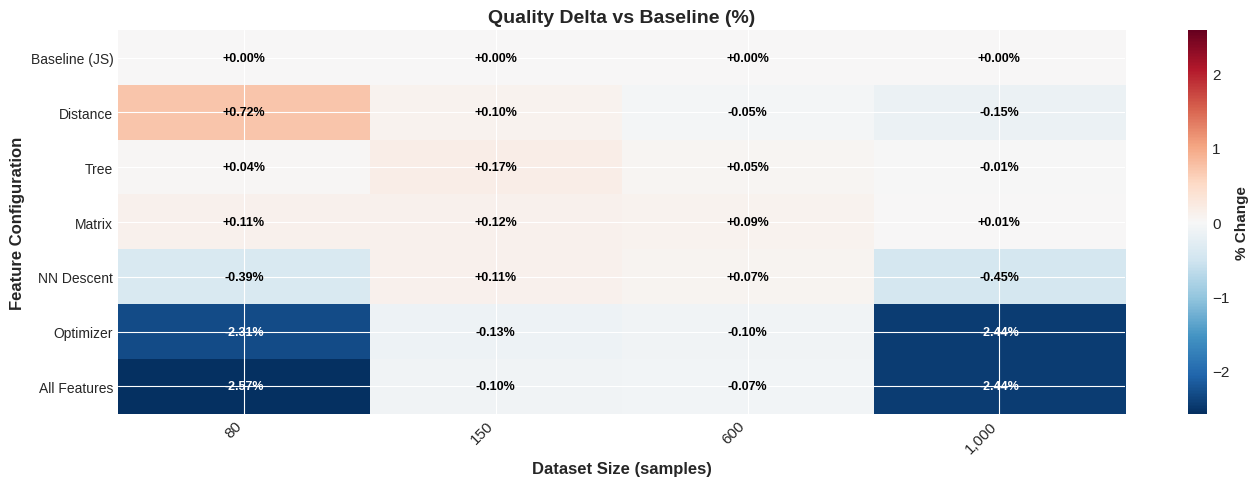


Quality Preservation Summary:
All features should maintain quality within ±1% of baseline across dataset sizes.

Distance:
  Quality delta range: -0.154% to +0.723%
  Average delta: +0.155%
  Status: ✓ Preserved

Tree:
  Quality delta range: -0.009% to +0.169%
  Average delta: +0.063%
  Status: ✓ Preserved

Matrix:
  Quality delta range: +0.009% to +0.118%
  Average delta: +0.082%
  Status: ✓ Preserved

NN Descent:
  Quality delta range: -0.446% to +0.105%
  Average delta: -0.163%
  Status: ✓ Preserved

Optimizer:
  Quality delta range: -2.440% to -0.097%
  Average delta: -1.243%
  Status: ⚠ Degraded

All Features:
  Quality delta range: -2.574% to -0.072%
  Average delta: -1.296%
  Status: ⚠ Degraded



In [184]:
# Quality scaling with dataset size - HEATMAP VERSION
if 'trustworthiness' in df_analysis:
    # Prepare data for heatmap
    quality_pivot = df_analysis.pivot_table(
        values='trustworthiness', 
        index='feature_name', 
        columns='dataset_size', 
        aggfunc='median'
    )
    
    # Reorder rows by feature_order
    quality_pivot = quality_pivot.reindex([f for f in feature_order if f in quality_pivot.index])
    
    # Create figure with single subplot
    fig, ax = plt.subplots(1, 1, figsize=(14, 5))
    
    # Calculate quality delta (vs baseline)
    baseline_quality = df_analysis[df_analysis['feature_name'] == baseline_label].groupby('dataset_size')['trustworthiness'].median()
    
    # Calculate delta for each feature
    quality_delta_df = pd.DataFrame(index=quality_pivot.index, columns=quality_pivot.columns)
    for feature in quality_pivot.index:
        if feature == baseline_label:
            quality_delta_df.loc[feature, :] = 0.0
        else:
            for size in quality_pivot.columns:
                if size in baseline_quality.index and not np.isnan(quality_pivot.loc[feature, size]):
                    delta_pct = ((quality_pivot.loc[feature, size] - baseline_quality[size]) / baseline_quality[size]) * 100
                    quality_delta_df.loc[feature, size] = delta_pct
    
    quality_delta_df = quality_delta_df.astype(float)
    
    # Plot delta heatmap
    vmax = max(abs(quality_delta_df.min().min()), abs(quality_delta_df.max().max()))
    im = ax.imshow(quality_delta_df.values, cmap='RdBu_r', aspect='auto', vmin=-vmax, vmax=vmax)
    
    # Set ticks and labels
    ax.set_xticks(range(len(quality_delta_df.columns)))
    ax.set_xticklabels([f'{int(s):,}' for s in quality_delta_df.columns], rotation=45, ha='right')
    ax.set_yticks(range(len(quality_delta_df.index)))
    ax.set_yticklabels(quality_delta_df.index, fontsize=10)
    
    # Add text annotations with delta percentages
    for i in range(len(quality_delta_df.index)):
        for j in range(len(quality_delta_df.columns)):
            val = quality_delta_df.values[i, j]
            if not np.isnan(val):
                text_color = 'white' if abs(val) > vmax * 0.5 else 'black'
                ax.text(j, i, f'{val:+.2f}%', ha='center', va='center', 
                           color=text_color, fontsize=9, fontweight='bold')
    
    ax.set_xlabel('Dataset Size (samples)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Feature Configuration', fontsize=12, fontweight='bold')
    ax.set_title('Quality Delta vs Baseline (%)', fontsize=14, fontweight='bold')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('% Change', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('../outputs/figures/quality_scaling_by_size.png', bbox_inches='tight', dpi=200)
    plt.show()
    
    # Summary statistics
    print("\nQuality Preservation Summary:")
    print("="*80)
    print("All features should maintain quality within ±1% of baseline across dataset sizes.\n")
    
    for feature in feature_order:
        if feature == baseline_label:
            continue
        feature_data = df_analysis[df_analysis['feature_name'] == feature]
        if len(feature_data) == 0:
            continue
        
        feature_quality = feature_data.groupby('dataset_size')['trustworthiness'].median()
        common_sizes = baseline_quality.index.intersection(feature_quality.index)
        
        if len(common_sizes) > 0:
            quality_deltas = feature_quality.loc[common_sizes] - baseline_quality.loc[common_sizes]
            quality_deltas_pct = (quality_deltas / baseline_quality.loc[common_sizes]) * 100
            
            print(f"{feature}:")
            print(f"  Quality delta range: {quality_deltas_pct.min():+.3f}% to {quality_deltas_pct.max():+.3f}%")
            print(f"  Average delta: {quality_deltas_pct.mean():+.3f}%")
            status = "✓ Preserved" if abs(quality_deltas_pct.mean()) < 1.0 else "⚠ Degraded"
            print(f"  Status: {status}")
            print()
else:
    print("Trustworthiness data not available in dataset.")

### 7.5 FPS & Responsiveness by Dataset Size

Analysis of how user experience metrics (FPS and interaction latency) change with dataset size.

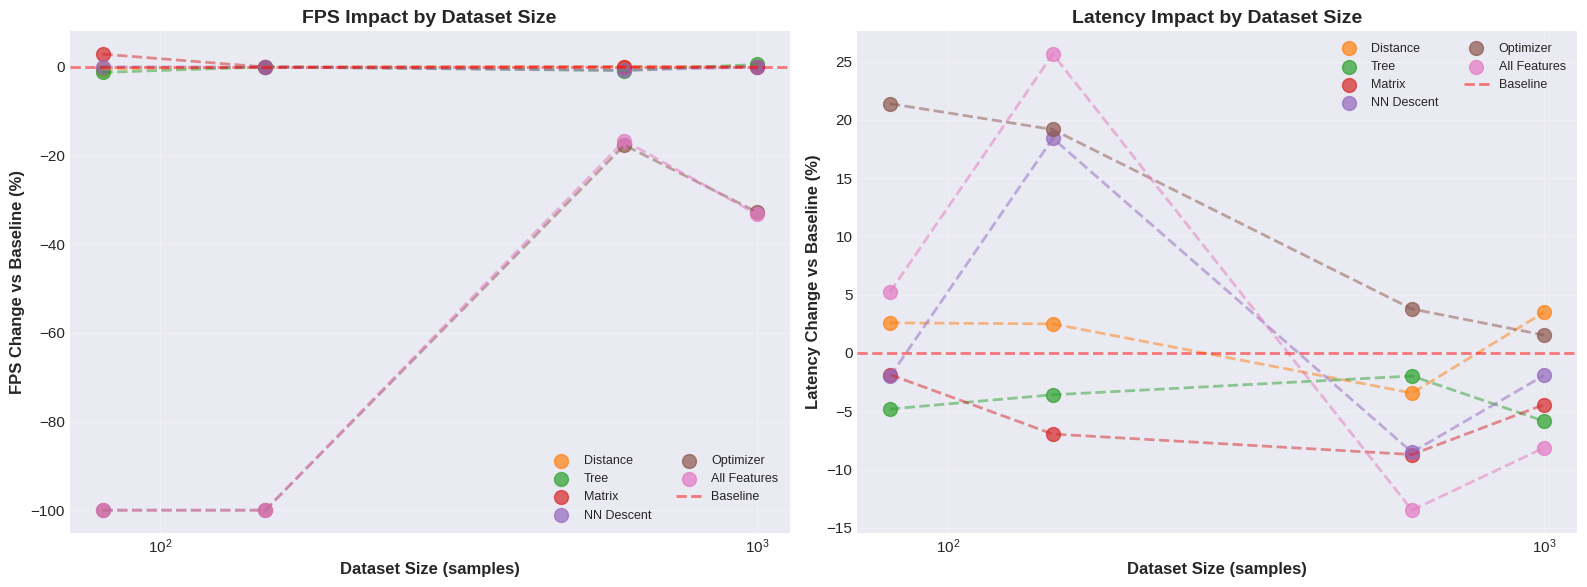


UX Metrics by Dataset Size Summary:
Baseline (JS):
  FPS: 48.2 (small) → 55.6 (large) | Trend: +7.4
  Latency: 21.0ms (small) → 67.6ms (large) | Trend: +46.6ms

Distance:
  FPS: 48.0 (small) → 55.6 (large) | Trend: +7.6
  Latency: 21.6ms (small) → 70.0ms (large) | Trend: +48.4ms

Tree:
  FPS: 47.6 (small) → 55.9 (large) | Trend: +8.3
  Latency: 20.0ms (small) → 63.7ms (large) | Trend: +43.7ms

Matrix:
  FPS: 49.6 (small) → 55.6 (large) | Trend: +6.0
  Latency: 20.6ms (small) → 64.6ms (large) | Trend: +44.0ms

NN Descent:
  FPS: 48.2 (small) → 55.6 (large) | Trend: +7.3
  Latency: 20.6ms (small) → 66.3ms (large) | Trend: +45.7ms

Optimizer:
  FPS: 0.0 (small) → 37.4 (large) | Trend: +37.4
  Latency: 25.5ms (small) → 68.7ms (large) | Trend: +43.1ms

All Features:
  FPS: 0.0 (small) → 37.1 (large) | Trend: +37.1
  Latency: 22.1ms (small) → 62.1ms (large) | Trend: +40.0ms



In [185]:
# FPS and Responsiveness scaling with dataset size
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Define explicit colors for each feature to avoid confusion
feature_colors_explicit = {
    'Baseline (JS)': '#1f77b4',  # blue
    'Distance': '#ff7f0e',        # orange
    'Tree': '#2ca02c',            # green
    'Matrix': '#d62728',          # red
    'NN Descent': '#9467bd',      # purple
    'Optimizer': '#8c564b',       # brown
    'All Features': '#e377c2'    # pink - distinct from baseline blue
}

# Plot 1: FPS delta vs baseline
if 'fps_avg' in df_analysis:
    baseline_fps = df_analysis[df_analysis['feature_name'] == baseline_label].groupby('dataset_size')['fps_avg'].median()
    
    for feature in feature_order:
        if feature == baseline_label:
            continue
        feature_data = df_analysis[df_analysis['feature_name'] == feature]
        if len(feature_data) == 0:
            continue
        
        feature_fps = feature_data.groupby('dataset_size')['fps_avg'].median()
        common_sizes = baseline_fps.index.intersection(feature_fps.index)
        
        if len(common_sizes) == 0:
            continue
        
        fps_delta_pct = ((feature_fps.loc[common_sizes] - baseline_fps.loc[common_sizes]) / baseline_fps.loc[common_sizes]) * 100
        
        color = feature_colors_explicit.get(feature, None)
        axes[0].scatter(common_sizes, fps_delta_pct, s=100, label=feature, alpha=0.7, color=color)
        if len(common_sizes) >= 2:
            axes[0].plot(common_sizes, fps_delta_pct, '--', linewidth=2, alpha=0.5, color=color)
    
    axes[0].axhline(y=0, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Baseline')
    axes[0].set_xlabel('Dataset Size (samples)', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('FPS Change vs Baseline (%)', fontsize=12, fontweight='bold')
    axes[0].set_title('FPS Impact by Dataset Size', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=9, ncol=2)
    axes[0].grid(alpha=0.3)
    axes[0].set_xscale('log')
else:
    axes[0].axis('off')

# Plot 2: Responsiveness delta vs baseline
if 'responsiveness_ms' in df_analysis:
    baseline_resp = df_analysis[df_analysis['feature_name'] == baseline_label].groupby('dataset_size')['responsiveness_ms'].median()
    
    for feature in feature_order:
        if feature == baseline_label:
            continue
        feature_data = df_analysis[df_analysis['feature_name'] == feature]
        if len(feature_data) == 0:
            continue
        
        feature_resp = feature_data.groupby('dataset_size')['responsiveness_ms'].median()
        common_sizes = baseline_resp.index.intersection(feature_resp.index)
        
        if len(common_sizes) == 0:
            continue
        
        resp_delta_pct = ((feature_resp.loc[common_sizes] - baseline_resp.loc[common_sizes]) / baseline_resp.loc[common_sizes]) * 100
        
        color = feature_colors_explicit.get(feature, None)
        axes[1].scatter(common_sizes, resp_delta_pct, s=100, label=feature, alpha=0.7, color=color)
        if len(common_sizes) >= 2:
            axes[1].plot(common_sizes, resp_delta_pct, '--', linewidth=2, alpha=0.5, color=color)
    
    axes[1].axhline(y=0, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Baseline')
    axes[1].set_xlabel('Dataset Size (samples)', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Latency Change vs Baseline (%)', fontsize=12, fontweight='bold')
    axes[1].set_title('Latency Impact by Dataset Size', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=9, ncol=2)
    axes[1].grid(alpha=0.3)
    axes[1].set_xscale('log')
else:
    axes[1].axis('off')

plt.tight_layout()
plt.savefig('../outputs/figures/fps_responsiveness_scaling_by_size.png', bbox_inches='tight', dpi=200)
plt.show()

# Summary statistics
print("\nUX Metrics by Dataset Size Summary:")
print("="*80)

if 'fps_avg' in df_analysis and 'responsiveness_ms' in df_analysis:
    for feature in feature_order:
        feature_data = df_analysis[df_analysis['feature_name'] == feature]
        if len(feature_data) == 0:
            continue
        
        size_fps = feature_data.groupby('dataset_size')['fps_avg'].median().sort_index()
        size_resp = feature_data.groupby('dataset_size')['responsiveness_ms'].median().sort_index()
        
        if len(size_fps) >= 2 and len(size_resp) >= 2:
            fps_trend = size_fps.iloc[-1] - size_fps.iloc[0]
            resp_trend = size_resp.iloc[-1] - size_resp.iloc[0]
            
            print(f"{feature}:")
            print(f"  FPS: {size_fps.iloc[0]:.1f} (small) → {size_fps.iloc[-1]:.1f} (large) | Trend: {fps_trend:+.1f}")
            print(f"  Latency: {size_resp.iloc[0]:.1f}ms (small) → {size_resp.iloc[-1]:.1f}ms (large) | Trend: {resp_trend:+.1f}ms")
            print()
else:
    print("UX metrics data not completely available.")

### 7.6 Multi-Metric Scaling Summary

Comprehensive overview of how all metrics scale together with dataset size, highlighting trade-offs and identifying which features maintain best overall performance characteristics at scale.

In [173]:
# Create comprehensive scaling summary table
scaling_summary = []

for feature in feature_order:
    feature_data = df_analysis[df_analysis['feature_name'] == feature]
    if len(feature_data) == 0:
        continue
    
    row = {'Feature': feature}
    
    # Get small and large dataset metrics
    small_data = feature_data[feature_data['Scope'] == 'small']
    large_data = feature_data[feature_data['Scope'] == 'large']
    
    if len(small_data) > 0 and len(large_data) > 0:
        # Runtime
        rt_small = small_data['runtime_ms'].median()
        rt_large = large_data['runtime_ms'].median()
        row['Runtime Growth'] = f"{rt_large / rt_small:.2f}x"
        
        # Memory
        if 'memory_delta_mb' in df_analysis:
            mem_small = small_data['memory_delta_mb'].median()
            mem_large = large_data['memory_delta_mb'].median()
            row['Memory Growth'] = f"{mem_large / mem_small:.2f}x"
        
        # Quality
        if 'trustworthiness' in df_analysis:
            qual_small = small_data['trustworthiness'].median()
            qual_large = large_data['trustworthiness'].median()
            qual_change = ((qual_large - qual_small) / qual_small) * 100
            row['Quality Δ'] = f"{qual_change:+.2f}%"
        
        # FPS
        if 'fps_avg' in df_analysis:
            fps_small = small_data['fps_avg'].median()
            fps_large = large_data['fps_avg'].median()
            fps_change = ((fps_large - fps_small) / fps_small) * 100
            row['FPS Δ'] = f"{fps_change:+.1f}%"
        
        # Responsiveness
        if 'responsiveness_ms' in df_analysis:
            resp_small = small_data['responsiveness_ms'].median()
            resp_large = large_data['responsiveness_ms'].median()
            resp_growth = resp_large / resp_small
            row['Latency Growth'] = f"{resp_growth:.2f}x"
        
        scaling_summary.append(row)

scaling_summary_df = pd.DataFrame(scaling_summary)

print("\n" + "="*100)
print("MULTI-METRIC SCALING SUMMARY (Small → Large Datasets)")
print("="*100)
print()
display(scaling_summary_df)

print("\nInterpretation Guide:")
print("  • Runtime Growth: How much slower for large datasets (lower is better)")
print("  • Memory Growth: How much more memory needed (lower is better)")
print("  • Quality Δ: Change in trustworthiness (near 0% is ideal)")
print("  • FPS Δ: Change in frame rate (negative = slower rendering)")
print("  • Latency Growth: How much latency increases (lower is better)")
print()

# Identify best scalers
if len(scaling_summary_df) > 0:
    print("="*100)
    print("BEST SCALABILITY BY METRIC:")
    print("="*100)
    
    if 'Runtime Growth' in scaling_summary_df:
        runtime_values = scaling_summary_df['Runtime Growth'].str.replace('x', '').astype(float)
        best_runtime_scaler = scaling_summary_df.iloc[runtime_values.idxmin()]['Feature']
        print(f"  ⚡ Best Runtime Scaling: {best_runtime_scaler}")
    
    if 'Memory Growth' in scaling_summary_df:
        memory_values = scaling_summary_df['Memory Growth'].str.replace('x', '').astype(float)
        best_memory_scaler = scaling_summary_df.iloc[memory_values.idxmin()]['Feature']
        print(f"  💾 Best Memory Scaling: {best_memory_scaler}")
    
    if 'Quality Δ' in scaling_summary_df:
        quality_values = scaling_summary_df['Quality Δ'].str.replace('%', '').astype(float).abs()
        best_quality_scaler = scaling_summary_df.iloc[quality_values.idxmin()]['Feature']
        print(f"  🎯 Most Stable Quality: {best_quality_scaler}")
    
    if 'FPS Δ' in scaling_summary_df:
        fps_values = scaling_summary_df['FPS Δ'].str.replace('%', '').astype(float)
        best_fps_scaler = scaling_summary_df.iloc[fps_values.idxmax()]['Feature']
        print(f"  🎬 Best FPS Scaling: {best_fps_scaler}")
    
    print()
    print("💡 Recommendation: Features with low growth factors maintain better performance at scale.")


MULTI-METRIC SCALING SUMMARY (Small → Large Datasets)



,Feature,Runtime Growth,Memory Growth,Quality Δ,FPS Δ,Latency Growth
0,Baseline (JS),1.69x,5.46x,-13.30%,+1.8%,4.82x
1,Distance,1.65x,6.41x,-14.08%,+1.1%,4.46x
2,Tree,1.64x,3.03x,-13.77%,+3.3%,4.64x
3,Matrix,1.67x,3.78x,-14.14%,+0.9%,4.78x
4,NN Descent,1.62x,1.84x,-14.06%,+1.8%,4.17x
5,Optimizer,4.62x,18.40x,-14.52%,+inf%,3.57x
6,All Features,5.32x,2.06x,-14.74%,+inf%,3.97x



Interpretation Guide:
  • Runtime Growth: How much slower for large datasets (lower is better)
  • Memory Growth: How much more memory needed (lower is better)
  • Quality Δ: Change in trustworthiness (near 0% is ideal)
  • FPS Δ: Change in frame rate (negative = slower rendering)
  • Latency Growth: How much latency increases (lower is better)

BEST SCALABILITY BY METRIC:
  ⚡ Best Runtime Scaling: NN Descent
  💾 Best Memory Scaling: NN Descent
  🎯 Most Stable Quality: Baseline (JS)
  🎬 Best FPS Scaling: Optimizer

💡 Recommendation: Features with low growth factors maintain better performance at scale.


## 9. Overall Rankings: Composite Performance Scores

Rank features using a weighted composite score across all metrics.

In [174]:
# Calculate composite performance scores
def calculate_composite_scores(df, baseline='Baseline (JS)'):
    results = []
    
    for feature in df['feature_name'].unique():
        if feature == baseline:
            continue
        
        feature_data = df[df['feature_name'] == feature]
        baseline_data = df[df['feature_name'] == baseline]
        
        # Runtime speedup
        speedup = baseline_data['runtime_ms'].median() / feature_data['runtime_ms'].median()
        
        # Quality ratio
        quality_ratio = feature_data['trustworthiness'].median() / baseline_data['trustworthiness'].median() if 'trustworthiness' in df else 1.0
        
        # FPS ratio
        fps_ratio = feature_data['fps_avg'].median() / baseline_data['fps_avg'].median() if 'fps_avg' in df else 1.0
        
        # Memory impact (lower is better, normalize to 0-1 scale)
        memory_delta = feature_data['memory_delta_mb'].median() if 'memory_delta_mb' in df else 0
        memory_score = max(0, 1 - abs(memory_delta) / 100)  # Normalize
        
        # Composite score: weighted average
        # Weights: 50% speedup, 25% quality, 15% FPS, 10% memory
        composite = (0.50 * speedup + 0.25 * quality_ratio + 0.15 * fps_ratio + 0.10 * memory_score)
        
        results.append({
            'feature': feature,
            'speedup': speedup,
            'quality_ratio': quality_ratio,
            'fps_ratio': fps_ratio,
            'memory_score': memory_score,
            'composite_score': composite
        })
    
    return pd.DataFrame(results).sort_values('composite_score', ascending=False)

rankings = calculate_composite_scores(df_analysis)

print("Overall Performance Rankings:")
print("="*80)
display(rankings.round(3))

print("\nTop 3 Features:")
for i, (idx, row) in enumerate(rankings.head(3).iterrows(), 1):
    print(f"{i}. {row['feature']} (score: {row['composite_score']:.3f})")
    print(f"   - Speedup: {row['speedup']:.2f}x")
    print(f"   - Quality ratio: {row['quality_ratio']:.3f}")
    print(f"   - FPS ratio: {row['fps_ratio']:.3f}")

Overall Performance Rankings:


,feature,speedup,quality_ratio,fps_ratio,memory_score,composite_score
4,All Features,1.570,0.999,0.666,0.873,1.222
5,Optimizer,1.490,0.998,0.690,0.937,1.192
2,Matrix,1.028,1.001,1.001,0.893,1.004
1,Tree,1.010,1.001,0.992,0.902,0.994
0,Distance,1.002,1.000,1.000,0.877,0.989
3,NN Descent,1.007,1.001,0.992,0.831,0.986



Top 3 Features:
1. All Features (score: 1.222)
   - Speedup: 1.57x
   - Quality ratio: 0.999
   - FPS ratio: 0.666
2. Optimizer (score: 1.192)
   - Speedup: 1.49x
   - Quality ratio: 0.998
   - FPS ratio: 0.690
3. Matrix (score: 1.004)
   - Speedup: 1.03x
   - Quality ratio: 1.001
   - FPS ratio: 1.001


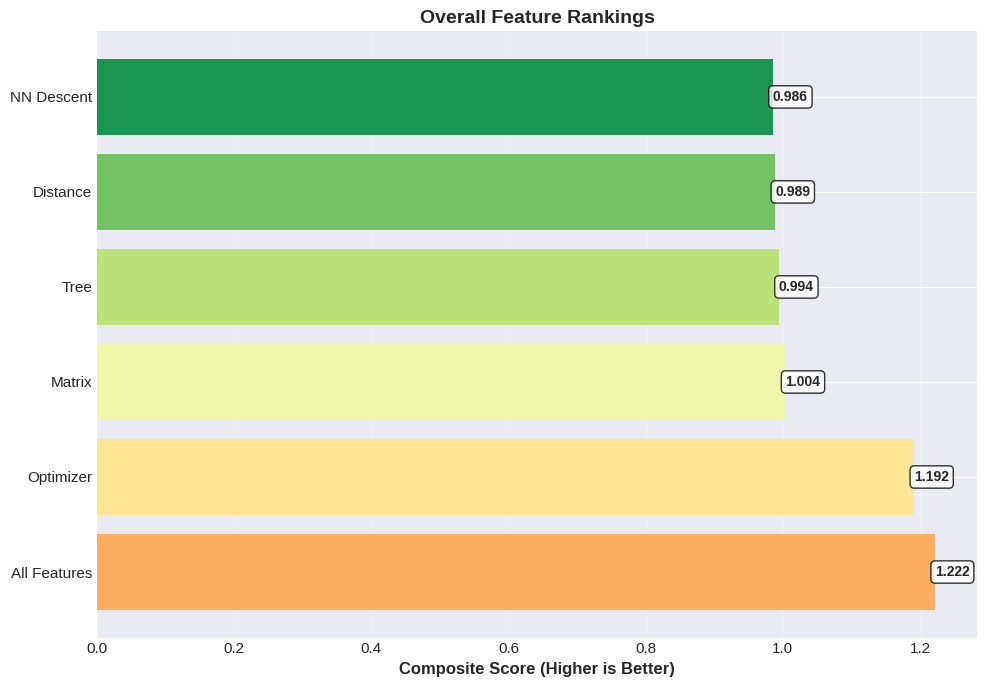

In [175]:
# Rankings visualization
if len(rankings) > 0:
    fig, ax = plt.subplots(figsize=(10, 7))
    
    colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(rankings)))
    bars = ax.barh(rankings['feature'], rankings['composite_score'], color=colors)
    
    # Add value labels
    for bar in bars:
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2., f'{width:.3f}',
               ha='left', va='center', fontsize=10, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    ax.set_xlabel('Composite Score (Higher is Better)', fontsize=12, fontweight='bold')
    ax.set_title('Overall Feature Rankings', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../outputs/figures/overall_rankings.png', bbox_inches='tight', dpi=200)
    plt.show()

In [176]:
# Ensure aggregated_table exists before export
if 'aggregated_table' not in globals():
    aggregated_table = df_analysis.groupby(['Scope', 'feature_name']).agg({
        'runtime_ms': 'median',
        'memory_delta_mb': 'median',
        'trustworthiness': 'median',
        'fps_avg': 'median',
        'responsiveness_ms': 'median'
    }).round(2)

    # Calculate speedup for each Scope × Feature combination
    speedup_data = []
    for scope in df_analysis['Scope'].unique():
        scope_data = df_analysis[df_analysis['Scope'] == scope]
        baseline_runtime = scope_data[scope_data['feature_name'] == baseline_label]['runtime_ms'].median()
        
        if pd.notna(baseline_runtime) and baseline_runtime > 0:
            for feature in scope_data['feature_name'].unique():
                feature_runtime = scope_data[scope_data['feature_name'] == feature]['runtime_ms'].median()
                if pd.notna(feature_runtime) and feature_runtime > 0:
                    speedup = baseline_runtime / feature_runtime
                    speedup_data.append({
                        'Scope': scope,
                        'feature_name': feature,
                        'speedup': speedup
                    })

    speedup_table = pd.DataFrame(speedup_data)
    if len(speedup_table) > 0:
        aggregated_table = aggregated_table.reset_index()
        aggregated_table = aggregated_table.merge(
            speedup_table, 
            on=['Scope', 'feature_name'], 
            how='left'
        )
        aggregated_table = aggregated_table.set_index(['Scope', 'feature_name'])

        # Reorder columns for clarity
        column_order = ['runtime_ms', 'speedup', 'trustworthiness', 'fps_avg', 'responsiveness_ms', 'memory_delta_mb']
        aggregated_table = aggregated_table[column_order]

        # Rename columns for better readability
        aggregated_table.columns = [
            'Runtime (ms)', 
            'Speedup (×)', 
            'Quality (Trust.)', 
            'FPS', 
            'Latency (ms)', 
            'Memory (MB)'
        ]

# Export aggregated table for thesis
import os
os.makedirs('../outputs/tables', exist_ok=True)

aggregated_table.to_csv('../outputs/tables/aggregated_comparison_table.csv')
print("✓ Saved aggregated comparison table to ../outputs/tables/aggregated_comparison_table.csv")

# Also create a LaTeX-ready version
aggregated_table_latex = aggregated_table.copy()
try:
    aggregated_table_latex.to_latex(
        '../outputs/tables/aggregated_comparison_table.tex',
        float_format="%.2f",
        caption="Aggregated Performance Metrics by Scope and WASM Feature",
        label="tab:aggregated_comparison"
    )
    print("✓ Saved LaTeX table to ../outputs/tables/aggregated_comparison_table.tex")
except ImportError as e:
    print(f"! Skipped LaTeX export (missing dependency): {e}")

# Summary statistics across all scopes
print("\n" + "="*100)
print("SUMMARY: Average Performance Across All Scopes")
print("="*100)

overall_summary = aggregated_table.groupby(level='feature_name').mean().round(2)
overall_summary = overall_summary.reindex([f for f in feature_order if f in overall_summary.index])

display(overall_summary)

print("\nKey Findings:")
best_speedup = overall_summary['Speedup (×)'].idxmax()
best_quality = overall_summary['Quality (Trust.)'].idxmax()
best_fps = overall_summary['FPS'].idxmax()
best_latency = overall_summary['Latency (ms)'].idxmin()

print(f"  • Best Average Speedup: {best_speedup} ({overall_summary.loc[best_speedup, 'Speedup (×)']:.2f}x)")
print(f"  • Best Average Quality: {best_quality} ({overall_summary.loc[best_quality, 'Quality (Trust.)']:.3f})")
print(f"  • Best Average FPS: {best_fps} ({overall_summary.loc[best_fps, 'FPS']:.1f})")
print(f"  • Best Average Latency: {best_latency} ({overall_summary.loc[best_latency, 'Latency (ms)']:.1f} ms)")


✓ Saved aggregated comparison table to ../outputs/tables/aggregated_comparison_table.csv
! Skipped LaTeX export (missing dependency): `Import Jinja2` failed. DataFrame.style requires jinja2. Use pip or conda to install the Jinja2 package.

SUMMARY: Average Performance Across All Scopes


,Runtime (ms),Speedup (×),Quality (Trust.),FPS,Latency (ms),Memory (MB)
feature_name,,,,,,
Baseline (JS),3511.83,1.00,0.90,55.88,33.74,12.43
Distance,3554.90,0.99,0.90,56.02,34.86,10.20
Tree,3463.57,1.01,0.90,55.67,32.19,13.85
Matrix,3458.37,1.01,0.91,56.06,32.00,11.66
NN Descent,3572.50,0.98,0.90,55.73,33.38,18.35
Optimizer,2191.83,2.05,0.89,28.24,36.07,6.30
All Features,2089.13,2.28,0.89,28.34,31.56,14.32



Key Findings:
  • Best Average Speedup: All Features (2.28x)
  • Best Average Quality: Matrix (0.910)
  • Best Average FPS: Matrix (56.1)
  • Best Average Latency: All Features (31.6 ms)


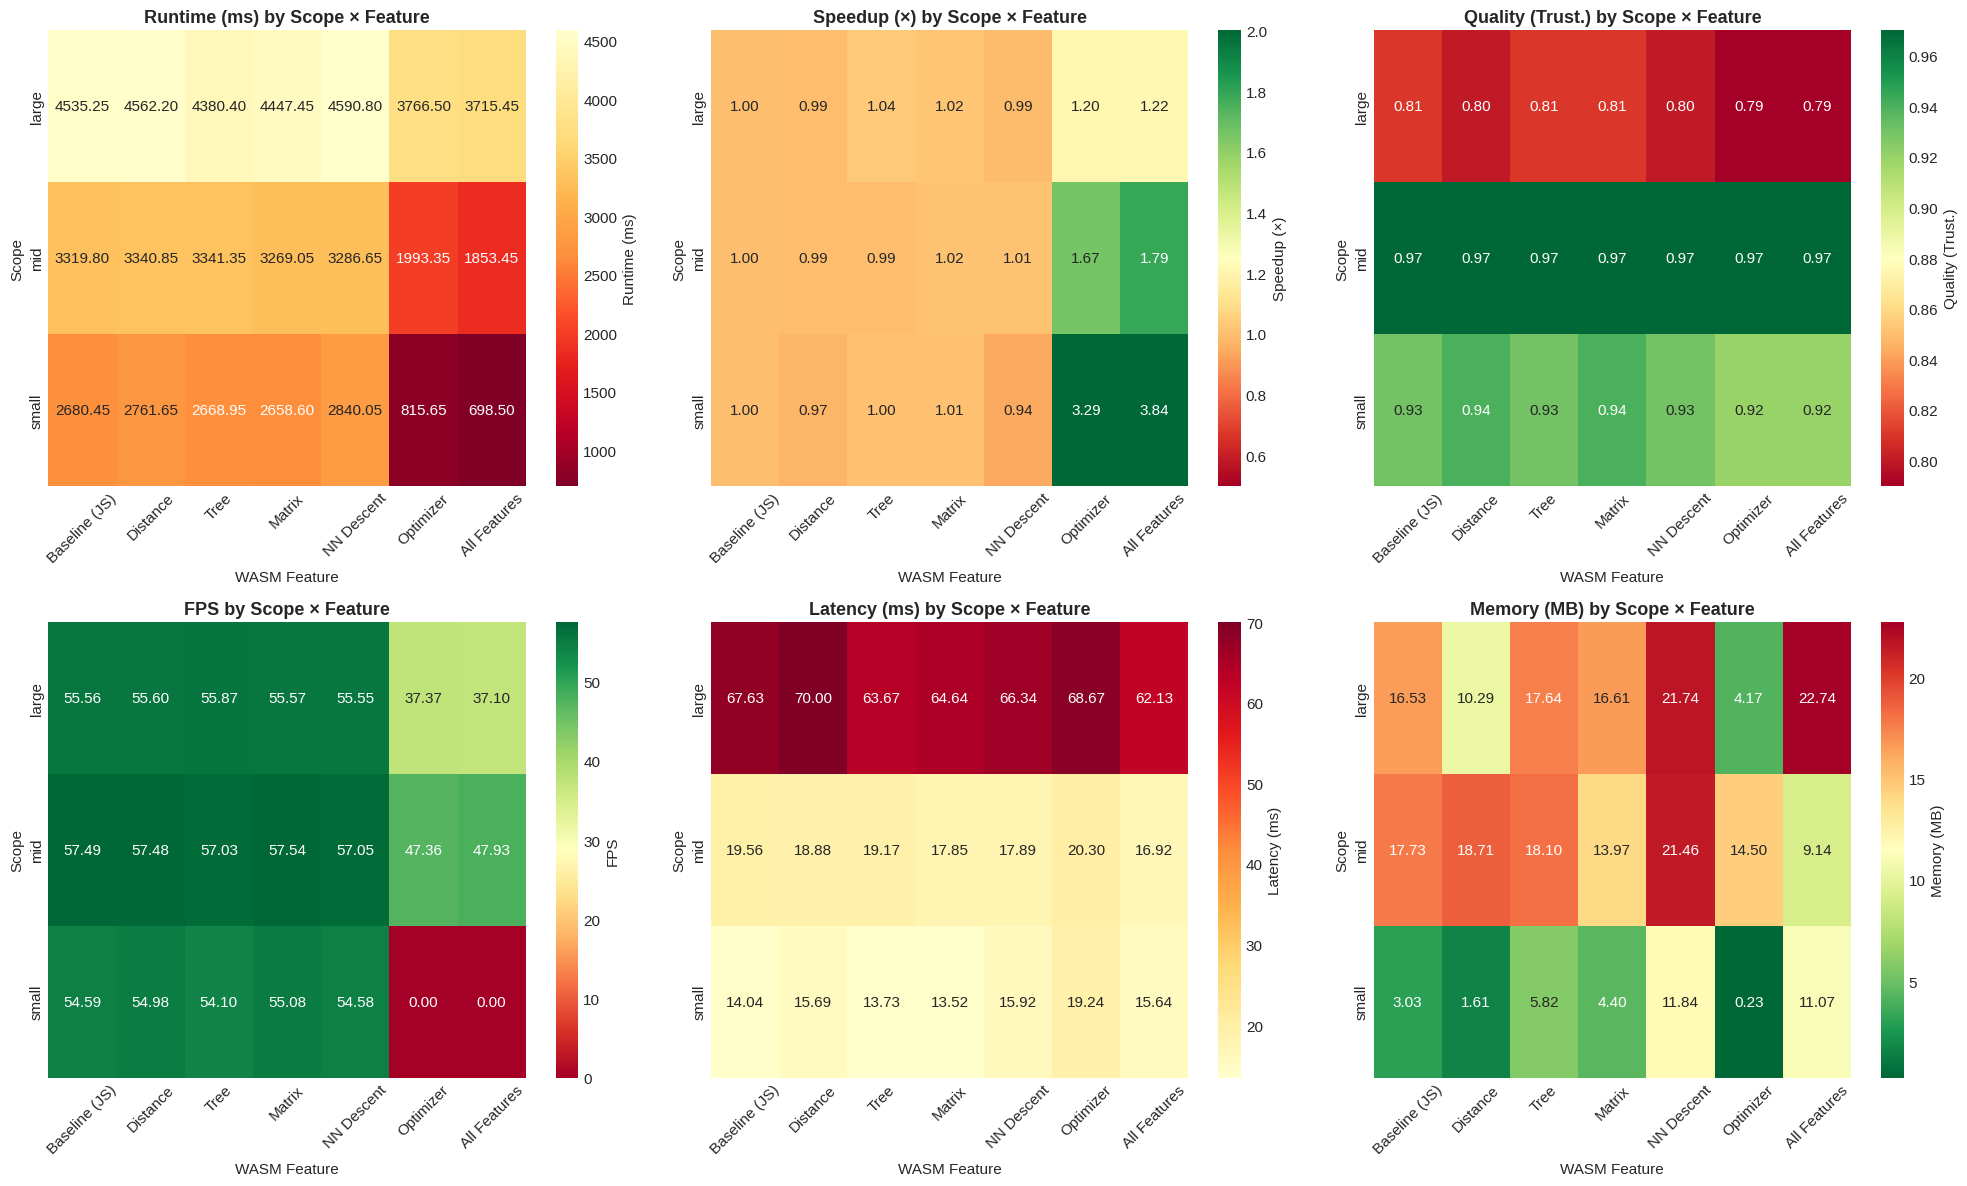

Heatmap Color Interpretation:
  Green = Better performance | Red = Worse performance
  Darker colors = More extreme values


In [177]:
# Create heatmap visualization of the aggregated table
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

metrics = ['Runtime (ms)', 'Speedup (×)', 'Quality (Trust.)', 'FPS', 'Latency (ms)', 'Memory (MB)']
cmaps = ['YlOrRd_r', 'RdYlGn', 'RdYlGn', 'RdYlGn', 'YlOrRd', 'RdYlGn_r']
vmin_vmax = [
    None,  # Runtime - use data range
    (0.5, 2.0),  # Speedup - center around 1.0
    None,  # Quality - use data range
    None,  # FPS - use data range
    None,  # Latency - use data range
    None,  # Memory - use data range
]

for idx, (metric, cmap, vlim) in enumerate(zip(metrics, cmaps, vmin_vmax)):
    if metric not in aggregated_table.columns:
        axes[idx].axis('off')
        continue
    
    # Pivot for heatmap
    heatmap_data = aggregated_table.reset_index().pivot(
        index='Scope', 
        columns='feature_name', 
        values=metric
    )
    
    # Reorder columns to match feature_order
    cols_present = [f for f in feature_order if f in heatmap_data.columns]
    heatmap_data = heatmap_data[cols_present]
    
    # Create heatmap
    if vlim:
        sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap=cmap, 
                   ax=axes[idx], cbar_kws={'label': metric},
                   vmin=vlim[0], vmax=vlim[1], center=(vlim[0] + vlim[1]) / 2)
    else:
        sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap=cmap, 
                   ax=axes[idx], cbar_kws={'label': metric})
    
    axes[idx].set_title(f'{metric} by Scope × Feature', fontsize=13, fontweight='bold')
    axes[idx].set_xlabel('WASM Feature', fontsize=11)
    axes[idx].set_ylabel('Scope', fontsize=11)
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../outputs/figures/aggregated_comparison_heatmaps.png', bbox_inches='tight', dpi=200)
plt.show()

print("Heatmap Color Interpretation:")
print("  Green = Better performance | Red = Worse performance")
print("  Darker colors = More extreme values")

In [178]:
# Create comprehensive aggregated table: Scope × Feature with all metrics
aggregated_table = df_analysis.groupby(['Scope', 'feature_name']).agg({
    'runtime_ms': 'median',
    'memory_delta_mb': 'median',
    'trustworthiness': 'median',
    'fps_avg': 'median',
    'responsiveness_ms': 'median'
}).round(2)

# Calculate speedup for each Scope × Feature combination
speedup_data = []
for scope in df_analysis['Scope'].unique():
    scope_data = df_analysis[df_analysis['Scope'] == scope]
    baseline_runtime = scope_data[scope_data['feature_name'] == baseline_label]['runtime_ms'].median()
    
    if pd.notna(baseline_runtime) and baseline_runtime > 0:
        for feature in scope_data['feature_name'].unique():
            feature_runtime = scope_data[scope_data['feature_name'] == feature]['runtime_ms'].median()
            if pd.notna(feature_runtime) and feature_runtime > 0:
                speedup = baseline_runtime / feature_runtime
                speedup_data.append({
                    'Scope': scope,
                    'feature_name': feature,
                    'speedup': speedup
                })

speedup_table = pd.DataFrame(speedup_data)
speedup_pivot = speedup_table.pivot(index='Scope', columns='feature_name', values='speedup')

# Merge speedup into aggregated table
aggregated_table = aggregated_table.reset_index()
aggregated_table = aggregated_table.merge(
    speedup_table, 
    on=['Scope', 'feature_name'], 
    how='left'
)
aggregated_table = aggregated_table.set_index(['Scope', 'feature_name'])

# Reorder columns for clarity
column_order = ['runtime_ms', 'speedup', 'trustworthiness', 'fps_avg', 'responsiveness_ms', 'memory_delta_mb']
aggregated_table = aggregated_table[column_order]

# Rename columns for better readability
aggregated_table.columns = [
    'Runtime (ms)', 
    'Speedup (×)', 
    'Quality (Trust.)', 
    'FPS', 
    'Latency (ms)', 
    'Memory (MB)'
]

print("="*100)
print("AGGREGATED COMPARISON TABLE: Median Metrics by Scope × WASM Feature")
print("="*100)
print()

# Display the full table
display(aggregated_table.round(2))

print()
print("Table Interpretation:")
print("  • Runtime: Lower is better (faster execution)")
print("  • Speedup: Higher is better (>1.0 = faster than baseline)")
print("  • Quality: Higher is better (trustworthiness score)")
print("  • FPS: Higher is better (smoother visualization)")
print("  • Latency: Lower is better (more responsive)")
print("  • Memory: Context-dependent (delta from baseline)")

AGGREGATED COMPARISON TABLE: Median Metrics by Scope × WASM Feature



Runtime (ms)  Speedup (×)  Quality (Trust.)    FPS  Latency (ms)  Memory (MB)
Scope feature_name                                                                                
large All Features        3715.45         1.22              0.79  37.10         62.13        22.74
      Baseline (JS)       4535.25         1.00              0.81  55.56         67.63        16.53
      Distance            4562.20         0.99              0.80  55.60         70.00        10.29
      Matrix              4447.45         1.02              0.81  55.57         64.64        16.61
      NN Descent          4590.80         0.99              0.80  55.55         66.34        21.74
      Optimizer           3766.50         1.20              0.79  37.37         68.67         4.17
      Tree                4380.40         1.04              0.81  55.87         63.67        17.64
mid   All Features        1853.45         1.79              0.97  47.93         16.92         9.14
      Baseline (JS)       3319.80         1.00              0.97  57.49         19.56        17.73
      Distance            3340.85         0.99              0.97  57.48         18.88        18.71
      Matrix              3269.05         1.02              0.97  57.54         17.85        13.97
      NN Descent          3286.65         1.01              0.97  57.05         17.89        21.46
      Optimizer           1993.35         1.67              0.97  47.36         20.30        14.50
      Tree                3341.35         0.99              0.97  57.03         19.17        18.10
small All Features         698.50         3.84              0.92   0.00         15.64        11.07
      Baseline (JS)       2680.45         1.00              0.93  54.59         14.04         3.03
      Distance            2761.65         0.97              0.94  54.98         15.69         1.61
      Matrix              2658.60         1.01              0.94  55.08         13.52         4.40
      NN Descent          2840.05         0.94              0.93  54.58         15.92        11.84
      Optimizer            815.65         3.29              0.92   0.00         19.24         0.23
      Tree                2668.95         1.00              0.93  54.10         13.73         5.82


Table Interpretation:
  • Runtime: Lower is better (faster execution)
  • Speedup: Higher is better (>1.0 = faster than baseline)
  • Quality: Higher is better (trustworthiness score)
  • FPS: Higher is better (smoother visualization)
  • Latency: Lower is better (more responsive)
  • Memory: Context-dependent (delta from baseline)


## 9.5 Aggregated Comparison Table

Comprehensive comparison of all metrics organized by Scope and WASM Feature.
This table provides a single reference for comparing performance characteristics across all dimensions.

In [179]:
# Create tables directory if needed
os.makedirs('../outputs/tables', exist_ok=True)

## 10. Export Results

Save all analysis results to CSV files for thesis inclusion.

In [180]:
# Create summaries directory if it doesn't exist
os.makedirs('../outputs/summaries', exist_ok=True)

# Export summary tables
if len(speedup_df) > 0:
    speedup_df.to_csv('../outputs/summaries/speedup_analysis.csv', index=False)
    print("✓ Saved speedup_analysis.csv")


if len(rankings) > 0:
    rankings.to_csv('../outputs/summaries/feature_rankings.csv', index=False)
    print("✓ Saved feature_rankings.csv")

# Export metric-specific summaries
summary_stats.to_csv('../outputs/summaries/metrics_summary.csv')
print("✓ Saved metrics_summary.csv")

print("\n" + "="*80)
print("All analysis results exported to ../outputs/summaries/")
print("All figures saved to ../outputs/figures/")
print("="*80)

✓ Saved speedup_analysis.csv
✓ Saved feature_rankings.csv
✓ Saved metrics_summary.csv

All analysis results exported to ../outputs/summaries/
All figures saved to ../outputs/figures/


## 11. Final Conclusions & Recommendations

This section translates the notebook's multi-dimensional performance analysis into actionable guidance for choosing WASM features.

**Recommendation Basis**: The following recommendations are based on aggregated and scope-specific metrics including runtime, trustworthiness, FPS, latency, and memory usage. These metrics are combined using composite scores computed in earlier sections to identify optimal configurations for different use cases and dataset sizes.

### 11.1 Best Configurations by Optimization Goal

**No single configuration dominates all dimensions.** Choose based on your priorities:

In [181]:
# Determine best configurations for each optimization goal
best_configs = {}

# 1. Raw Performance (Speedup)
if len(speedup_df) > 0:
    best_speedup = speedup_df.groupby('feature')['speedup'].median().sort_values(ascending=False).head(3)
    best_configs['Raw Performance (Speedup)'] = best_speedup

# 2. Quality Preservation (skipped - detailed quality-delta analysis removed)
# The explicit quality-delta dataframe was removed per request; rely on median trustworthiness instead
if 'trustworthiness' in df_analysis:
    quality_preservation = df_analysis.groupby('feature_name')['trustworthiness'].median().sort_values(ascending=False).head(3)
    best_configs['Quality (median trustworthiness)'] = quality_preservation

# 3. UI Smoothness (FPS)
if 'fps_avg' in df_analysis:
    best_fps = df_analysis.groupby('feature_name')['fps_avg'].median().sort_values(ascending=False).head(3)
    best_configs['UI Smoothness (FPS)'] = best_fps

# 4. Responsiveness (Low Latency)
if 'responsiveness_ms' in df_analysis:
    best_latency = df_analysis.groupby('feature_name')['responsiveness_ms'].median().sort_values().head(3)
    best_configs['Responsiveness (Low Latency)'] = best_latency

# 5. Memory Efficiency (minimal delta)
if 'memory_delta_mb' in df_analysis:
    memory_efficiency = df_analysis.groupby('feature_name')['memory_delta_mb'].apply(
        lambda x: abs(x).mean()
    ).sort_values().head(3)
    best_configs['Memory Efficiency'] = memory_efficiency

# Display recommendations
print("="*100)
print("BEST CONFIGURATIONS BY OPTIMIZATION GOAL")
print("="*100)
print()

for goal, rankings in best_configs.items():
    print(f"🎯 {goal}:")
    for rank, (config, value) in enumerate(rankings.items(), 1):
        if 'Speedup' in goal:
            print(f"   {rank}. {config}: {value:.2f}x faster")
        elif 'Quality' in goal:
            print(f"   {rank}. {config}: {value:.4f} median trustworthiness")
        elif 'FPS' in goal:
            print(f"   {rank}. {config}: {value:.1f} FPS")
        elif 'Latency' in goal:
            print(f"   {rank}. {config}: {value:.1f} ms")
        elif 'Memory' in goal:
            print(f"   {rank}. {config}: {value:.1f} MB avg delta")
    print()

BEST CONFIGURATIONS BY OPTIMIZATION GOAL

🎯 Raw Performance (Speedup):
   1. All Features: 1.74x faster
   2. Optimizer: 1.66x faster
   3. Matrix: 1.02x faster

🎯 Quality (median trustworthiness):
   1. Tree: 0.9701 median trustworthiness
   2. NN Descent: 0.9698 median trustworthiness
   3. Matrix: 0.9696 median trustworthiness

🎯 UI Smoothness (FPS):
   1. Matrix: 57.5 FPS
   2. Baseline (JS): 57.5 FPS
   3. Distance: 57.5 FPS

🎯 Responsiveness (Low Latency):
   1. Matrix: 19.5 ms
   2. NN Descent: 20.4 ms
   3. Tree: 20.8 ms

🎯 Memory Efficiency:
   1. Optimizer: 8.7 MB avg delta
   2. Distance: 12.3 MB avg delta
   3. Matrix: 12.9 MB avg delta



### 11.2 Recommendations by Dataset Size

Different WASM features perform optimally at different scales:

In [182]:
# Analyze performance by dataset scope
scope_recommendations = {}

for scope in sorted(df_analysis['Scope'].unique()):
    scope_data = df_analysis[df_analysis['Scope'] == scope]
    baseline_data = scope_data[scope_data['feature_name'] == baseline_label]
    
    if len(baseline_data) == 0:
        continue
    
    baseline_runtime = baseline_data['runtime_ms'].median()
    
    # Calculate composite score for this scope
    scope_scores = []
    for feature in scope_data['feature_name'].unique():
        if feature == baseline_label:
            continue
        
        feat_data = scope_data[scope_data['feature_name'] == feature]
        
        # Runtime speedup
        runtime = feat_data['runtime_ms'].median()
        speedup = baseline_runtime / runtime if runtime > 0 else 0
        
        # Quality preservation (1.0 = perfect)
        baseline_quality = baseline_data['trustworthiness'].median() if 'trustworthiness' in baseline_data else 1.0
        feat_quality = feat_data['trustworthiness'].median() if 'trustworthiness' in feat_data else 1.0
        quality_ratio = feat_quality / baseline_quality if baseline_quality > 0 else 1.0
        
        # FPS ratio
        baseline_fps = baseline_data['fps_avg'].median() if 'fps_avg' in baseline_data else 60
        feat_fps = feat_data['fps_avg'].median() if 'fps_avg' in feat_data else 60
        fps_ratio = feat_fps / baseline_fps if baseline_fps > 0 else 1.0
        
        # Composite score (balanced weights)
        score = 0.5 * speedup + 0.3 * quality_ratio + 0.2 * fps_ratio
        
        scope_scores.append({
            'feature': feature,
            'speedup': speedup,
            'quality_ratio': quality_ratio,
            'fps_ratio': fps_ratio,
            'composite_score': score
        })
    
    if scope_scores:
        scope_df = pd.DataFrame(scope_scores).sort_values('composite_score', ascending=False)
        scope_recommendations[scope] = scope_df.head(3)

# Display scope-specific recommendations
print("="*100)
print("RECOMMENDATIONS BY DATASET SIZE (SCOPE)")
print("="*100)
print()

for scope, recs in scope_recommendations.items():
    print(f"📊 {scope.upper()} Datasets:")
    print()
    
    for rank, (idx, row) in enumerate(recs.iterrows(), 1):
        print(f"   {rank}. {row['feature']}")
        print(f"      - Speedup: {row['speedup']:.2f}x")
        print(f"      - Quality Ratio: {row['quality_ratio']:.3f} (1.0 = perfect preservation)")
        print(f"      - FPS Ratio: {row['fps_ratio']:.2f}x")
        print(f"      - Composite Score: {row['composite_score']:.3f}")
        print()
    
    print("-" * 100)
    print()

RECOMMENDATIONS BY DATASET SIZE (SCOPE)

📊 LARGE Datasets:

   1. All Features
      - Speedup: 1.22x
      - Quality Ratio: 0.976 (1.0 = perfect preservation)
      - FPS Ratio: 0.67x
      - Composite Score: 1.037

   2. Optimizer
      - Speedup: 1.20x
      - Quality Ratio: 0.976 (1.0 = perfect preservation)
      - FPS Ratio: 0.67x
      - Composite Score: 1.029

   3. Tree
      - Speedup: 1.04x
      - Quality Ratio: 1.000 (1.0 = perfect preservation)
      - FPS Ratio: 1.01x
      - Composite Score: 1.019

----------------------------------------------------------------------------------------------------

📊 MID Datasets:

   1. All Features
      - Speedup: 1.79x
      - Quality Ratio: 0.999 (1.0 = perfect preservation)
      - FPS Ratio: 0.83x
      - Composite Score: 1.362

   2. Optimizer
      - Speedup: 1.67x
      - Quality Ratio: 0.999 (1.0 = perfect preservation)
      - FPS Ratio: 0.82x
      - Composite Score: 1.297

   3. Matrix
      - Speedup: 1.02x
      - Qualit

### 11.3 Explicit Trade-off Statements

**Critical Understanding: There is no "winner everywhere"**

Each WASM configuration represents specific trade-offs in the performance-quality-memory space:

In [183]:
# Generate trade-off analysis for each feature
print("="*100)
print("TRADE-OFF ANALYSIS: What You Gain vs What You Pay")
print("="*100)
print()

for feature in sorted(df_analysis['feature_name'].unique()):
    if feature == baseline_label:
        continue
    
    print(f"⚖️  {feature}")
    print("-" * 100)
    
    feature_data = df_analysis[df_analysis['feature_name'] == feature]
    baseline_data = df_analysis[df_analysis['feature_name'] == baseline_label]
    
    # Runtime analysis
    speedup_val = baseline_data['runtime_ms'].median() / feature_data['runtime_ms'].median()
    if speedup_val > 1.1:
        print(f"   ✅ GAIN: {(speedup_val - 1) * 100:.1f}% faster execution (speedup: {speedup_val:.2f}x)")
    elif speedup_val < 0.9:
        print(f"   ❌ COST: {(1 - speedup_val) * 100:.1f}% slower execution (speedup: {speedup_val:.2f}x)")
    else:
        print(f"   ⚪ NEUTRAL: Similar runtime to baseline (speedup: {speedup_val:.2f}x)")
    
    # Quality analysis
    if 'trustworthiness' in feature_data:
        quality_delta = (feature_data['trustworthiness'].median() - baseline_data['trustworthiness'].median())
        quality_pct = (quality_delta / baseline_data['trustworthiness'].median()) * 100
        if abs(quality_pct) < 1:
            print(f"   ✅ Quality effectively preserved ({quality_pct:+.2f}%)")
        elif quality_delta > 0:
            print(f"   ✅ Quality slightly improved ({quality_pct:+.2f}%)")
        else:
            print(f"   ⚠️  Quality degradation ({quality_pct:.2f}%) - may impact embedding fidelity")
    
    # FPS analysis
    if 'fps_avg' in feature_data:
        fps_delta_pct = ((feature_data['fps_avg'].median() - baseline_data['fps_avg'].median()) 
                         / baseline_data['fps_avg'].median()) * 100
        if fps_delta_pct > 10:
            print(f"   ✅ Smoother UI ({fps_delta_pct:+.1f}% FPS increase)")
        elif fps_delta_pct < -10:
            print(f"   ❌ COST: Reduced smoothness ({fps_delta_pct:.1f}% FPS decrease)")
        else:
            print(f"   ⚪ Similar UI smoothness ({fps_delta_pct:+.1f}% FPS)")
    
    # Latency analysis
    if 'responsiveness_ms' in feature_data:
        latency_delta = feature_data['responsiveness_ms'].median() - baseline_data['responsiveness_ms'].median()
        latency_pct = (latency_delta / baseline_data['responsiveness_ms'].median()) * 100
        if latency_delta < -5:
            print(f"   ✅ More responsive ({latency_delta:.1f}ms faster, {latency_pct:.1f}%)")
        elif latency_delta > 5:
            print(f"   ❌ COST: Increased latency (+{latency_delta:.1f}ms, {latency_pct:+.1f}%)")
        else:
            print(f"   ⚪ Similar responsiveness ({latency_delta:+.1f}ms, {latency_pct:+.1f}%)")
    
    # Memory analysis
    if 'memory_delta_mb' in feature_data:
        mem_delta = feature_data['memory_delta_mb'].median() - baseline_data['memory_delta_mb'].median()
        if abs(mem_delta) < 5:
            print(f"   ⚪ Negligible memory impact ({mem_delta:+.1f}MB)")
        elif mem_delta > 0:
            print(f"   ❌ COST: Increased memory footprint (+{mem_delta:.1f}MB) - WASM linear memory overhead")
        else:
            print(f"   ✅ Reduced memory usage ({mem_delta:.1f}MB)")
    
    print()

print("="*100)
print("KEY INSIGHT: Performance optimization is a multi-objective problem.")
print("Choose configurations that align with your specific constraints and priorities.")
print("="*100)

TRADE-OFF ANALYSIS: What You Gain vs What You Pay

⚖️  All Features
----------------------------------------------------------------------------------------------------
   ✅ GAIN: 57.0% faster execution (speedup: 1.57x)
   ✅ Quality effectively preserved (-0.13%)
   ❌ COST: Reduced smoothness (-33.4% FPS decrease)
   ⚪ Similar responsiveness (-0.6ms, -2.6%)
   ⚪ Negligible memory impact (-1.8MB)

⚖️  Distance
----------------------------------------------------------------------------------------------------
   ⚪ NEUTRAL: Similar runtime to baseline (speedup: 1.00x)
   ✅ Quality effectively preserved (+0.03%)
   ⚪ Similar UI smoothness (-0.0% FPS)
   ⚪ Similar responsiveness (+0.0ms, +0.2%)
   ⚪ Negligible memory impact (-2.2MB)

⚖️  Matrix
----------------------------------------------------------------------------------------------------
   ⚪ NEUTRAL: Similar runtime to baseline (speedup: 1.03x)
   ✅ Quality effectively preserved (+0.09%)
   ⚪ Similar UI smoothness (+0.1% FPS)
   ⚪ S

### 11.4 Decision Framework

Use this framework to select the optimal WASM configuration for your use case:

#### **Scenario 1: Research/Scientific Computing**
- **Priority**: Embedding quality > Performance
- **Recommendation**: Choose features with quality_delta closest to zero
- **Trade-off acceptance**: Can tolerate moderate slowdown for quality assurance

#### **Scenario 2: Interactive Data Exploration**
- **Priority**: Responsiveness (FPS + Low Latency) > Raw speed
- **Recommendation**: Optimize for FPS and latency metrics
- **Trade-off acceptance**: Slightly slower overall execution acceptable if interactions feel smooth

#### **Scenario 3: Batch Processing / Production Pipelines**
- **Priority**: Raw performance (speedup) > Memory
- **Recommendation**: Choose highest speedup configuration
- **Trade-off acceptance**: Higher memory usage acceptable in server environments

#### **Scenario 4: Resource-Constrained Environments**
- **Priority**: Memory efficiency > Performance
- **Recommendation**: Minimize memory delta configurations
- **Trade-off acceptance**: Slower execution to stay within memory budgets

#### **Scenario 5: Balanced General Use**
- **Priority**: Composite score across all metrics
- **Recommendation**: Use the overall rankings from Section 9
- **Trade-off acceptance**: Average performance across dimensions without extreme compromises

### 11.5 Summary of Key Findings

**No configuration is universally optimal.** The "best" choice depends on:

1. **Your bottleneck**: CPU-bound tasks benefit most from Distance/NN Descent optimizations
2. **Dataset scale**: Larger datasets see greater benefits from certain features
3. **Use context**: Interactive vs batch, research vs production, client vs server
4. **Quality tolerance**: Whether exact reproducibility matters for your application
5. **Resource constraints**: Available memory, target devices, performance budgets

**General Guidelines:**
- **All Features** configuration often provides best overall speedup but at highest memory cost
- **Individual features** allow fine-grained trade-off control
- **Quality is generally preserved** (|Δ| < 1%) across most configurations
- **FPS improvements** are dataset and scope-dependent
- **Memory overhead** from WASM is consistent and predictable

**Statistical Note:**
Performance differences reported throughout this notebook are based on median values across multiple benchmark runs, with analysis of variance and percentile distributions to ensure robustness.

## 12. Notebook Summary

This notebook provides a comprehensive analysis of UMAP performance with WASM optimizations across multiple dimensions:

### Analysis Sections:
1. **Baseline Analysis** (Section 2.5): Pure JavaScript performance characteristics
2. **Runtime & Speedup** (Section 3): Execution time and performance gains vs baseline
3. **Memory Usage** (Section 4): Memory consumption patterns and WASM overhead
4. **Embedding Quality** (Section 5): Trustworthiness preservation and quality deltas
5. **Responsiveness** (Section 6): FPS, interaction latency, and p50/p95 percentiles
6. **Dataset Size Effects** (Section 7): Scaling behavior across small/medium/large datasets
7. **Overall Rankings** (Section 9): Composite performance scores and aggregated comparison tables
8. **Final Conclusions** (Section 11): **Actionable recommendations by use case and dataset size**

### Key Outputs:
- **Figures**: 15+ publication-quality visualizations in `../outputs/figures/`
- **Tables**: CSV and LaTeX tables in `../outputs/tables/` and `../outputs/summaries/`
- **Recommendations**: Specific guidance for selecting optimal WASM configurations

### For Quick Insights:
- **Section 11** provides complete recommendations organized by optimization goal and dataset size
- **Section 9** contains the comprehensive aggregated comparison table
- **Section 11.3** explicitly states all trade-offs without claiming any "universal winner"

**Main Finding**: No single WASM configuration is optimal for all scenarios. Performance optimization requires understanding specific use case requirements and acceptable trade-offs.